# Credit Card Fraud Detection

## Introduction

Credit card fraud occurs when a third party uses an individual’s credit card information to make unauthorised transactions, typically to make purchases or to obtain funds illegally.

Credit card companies should be able to flag these fraudulent transactions so that the credit card owner or customer is not charged for the purchases they did not make. The credit card company must, nevertheless, should be able to correctly identify fraudulent activity on the card to prevent blocking the credit card for genuine transactions. 


## Problem Statement

The goal of the project is to develop a machine learning model capable of accurately detecting fraudulent transactions in credit card data. 

## Objective

The main objective of this project is to train multiple supervised machine learning models and select the most optimal model which is able accurately identify fraudulent transactions in credit card. To acquire a comprehensive understanding of the data at hand, we initially conduct a thorough exploratory data analysis. After EDA we start with modelling, the data is first split into train and test dataset and then trained on the model. we have selected five predictive classifiers for this which include -

   1. Random Forest Classifier
   2. ADABoost Classifier
   3. CATBoost Classifier
   4. XGBoost Classifier
   5. LightGBM Classifier
   
The result of each model is analysed using standard metrics like precision-recall-f1, confusion matrix, Area under ROC curve. As the data contains highly imbalanced classes, the result of these standard metrics is not likely to give meaningful results. We address the imbalance in training data using techniques like SMOTE and ADASYN, then the models are trained on the resampled balanced train data. We also want to highlight the importance of balancing classes, while also trying to find a metric that works best for imbalanced classes. The models are then evaluated using accuracy using Area under precision recall curve (AUPRC) to obtain the best or the most optimum model.

## Import Libraries

In [66]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
import math
import matplotlib
import sklearn
from IPython.display import HTML
from IPython.display import YouTubeVideo

import pickle
import os

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots



from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import IsolationForest

In [289]:
# Load the library for splitting the data
from sklearn.model_selection import train_test_split
import tensorflow as tf

# About The Dataset

The data contains various features of credit card transaction history, the features V1, V2, V3, …, V28 have been transformed with PCA due to confidentiality, these features could be credit card information and other sensitive information of customers.

The dataset contains the information of credit card transaction for two days [15], where we have 492 fraud transactions out of a toatal of 284,807 transactions. The dataset is highly imbalanced, the positive class (fraud) account for 0.172% of all transactions. The sensitive information has been transformed using PCA for safety of the credit card users. The dataset was obtained from Kaggle - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data. 

The non-transformed features that we will work with are.

   - Time - This feature contains the seconds elapsed between each transaction and the first transaction in the dataset. 
   - Amount - This is the transaction Amount, which can be used for example-dependant cost-sensitive learning.
   - Class: The class variable has two values and identifies the transaction as genuine or fraud. The values are:
               1. 0 - Not Fraud
               2. 1 - Fraud

               
**Acknowledgements**
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

*ref - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data* 

In [3]:
df = pd.read_csv('creditcard.csv')

#### Raw Data

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis (EDA)

In [8]:
df.isnull().sum().sum()

0

There were no missing values found in our dataset.

In [7]:
print(df['Class'].value_counts())
print('\n')
print(df['Class'].value_counts(normalize=True))

0    284315
1       492
Name: Class, dtype: int64


0    0.998273
1    0.001727
Name: Class, dtype: float64


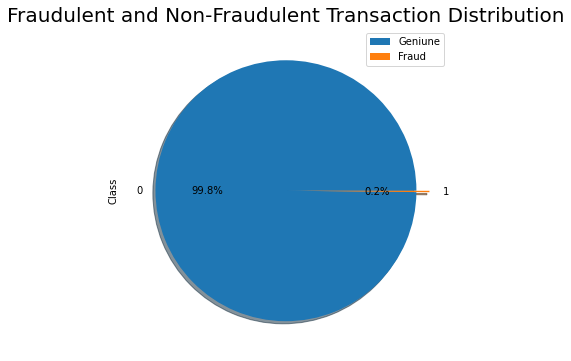

In [10]:
df["Class"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Fraudulent and Non-Fraudulent Transaction Distribution",fontsize=20)
plt.legend(["Geniune", "Fraud"])
plt.show()

#### Insights
1. As seen in the plot above the classes are highly imbalanced. The dataset consists of up to 0.2% of fraudulent transactions, that is 492 fraud incidents out of total 2,84,807 transactions, leaving 284315 genuine transactions. 
2. Using an imbalanced dataset for predictive models can result into overfitting of the machine learning models. Hence, we cannot use this dataset as is and we need to do some preprocessing to take care of the imbalanced classes before we proceed to modelling. 

Let us first analyse other variables of the dataset as well.


In [17]:
df[['Time','Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


#### Insights
1. Average transaction amount is 88.34, while average time lapse between consecutive transactions is 94813 seconds.
2. The credit card is used for a minimum amount of 0.00 and maximum amount of 25691.16.

In [14]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

In [15]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.000000,284315.000000
mean,122.211321,88.291022
std,256.683288,250.105092
min,0.000000,0.000000
25%,1.000000,5.650000
50%,9.250000,22.000000
75%,105.890000,77.050000
max,2125.870000,25691.160000


#### Insights
1. It can be seen in the chart above the average amount of fraudulent transactions is around 122.2, while the average amount for genuine transaction is 88.2.
2. Looking at the 75% amount value and Max amount value for both type of transactions we can say that the feature "Amount" is positively skewed.

Let us analyse the distribution of Amount to get more clarity.

## Distribution of Amount

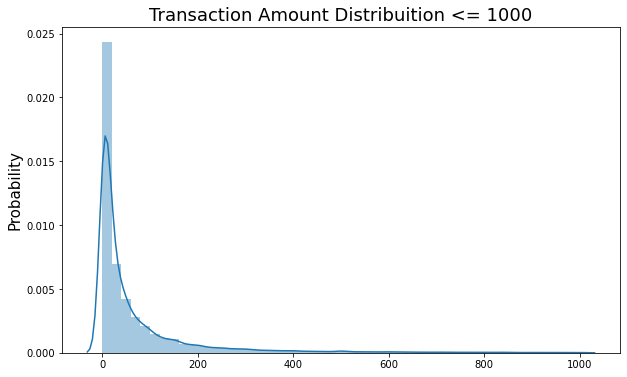

In [24]:
plt.figure(figsize=(10,6))
g = sns.distplot(df[df['Amount'] <= 1000]['Amount'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.show()

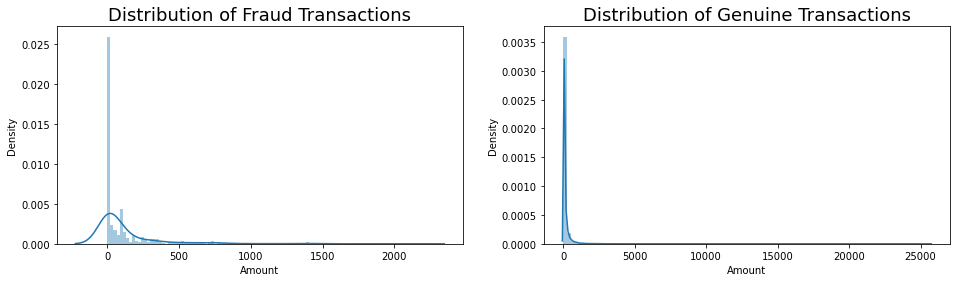

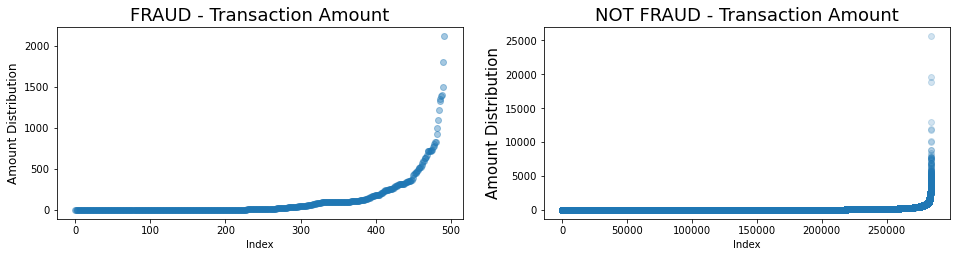

In [30]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.distplot(df[df['Class'] == 1]['Amount'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions", fontsize=18)

sns.distplot(df[df['Class'] == 0]['Amount'], bins=100, ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions", fontsize=18)

plt.show()

plt.figure(figsize=(16, 12))

plt.subplot(321)
p = plt.scatter(range(df[df['Class'] == 1].shape[0]), 
                 np.sort(df[df['Class'] == 1]['Amount'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
p1 = plt.scatter(range(df[df['Class'] == 0].shape[0]),
                 np.sort(df[df['Class'] == 0]['Amount'].values), 
                 label='NoFraud', alpha=.2)
p1= plt.title("GENUINE - Transaction Amount", fontsize=18)
p1 = plt.xlabel("Index")
p1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.show()

#### Insights

1. We can see from the above graphs that most of the fraudulent transaction amount is less than 500. We can also see there are some fraudulent transactions for an amount value of 0. Let us investigate this more.

In [32]:
print("Fraud Transaction distribution : \n",
      df[(df['Class'] == 1)]['Amount'].value_counts().head())
print("\n")
print("Maximum amount of fraud transaction - ",df[(df['Class'] == 1)]['Amount'].max())
print("Minimum amount of fraud transaction - ",df[(df['Class'] == 1)]['Amount'].min())

Fraud Transaction distribution : 
 1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: Amount, dtype: int64


Maximum amount of fraud transaction -  2125.87
Minimum amount of fraud transaction -  0.0


#### Insights 

1. From the above distribution chart we can see there are 113 transactions made for an amount of 1.00, and 27 transactions for amount between 0.76 to 0.77. Aside from this, we have 27 transactions for an amount of 99.99. 
2. Apart from this we have 27 transactions for an amount of 0(represented by the peak in our plots before). A Zero Value Transaction enables a merchant to request a Tokenised Card Number without presenting the transaction for authorisation [1]. it is a verification method used to verify credit cards and the card holder's information by storing it in a token. After that, a new transaction is made using this token to charge the credit card for the purchase.

We will now check the distribution for normal transaction.

In [33]:
print("Not Fraud Transaction distribution : \n",
      df[(df['Class'] == 0)]['Amount'].value_counts().head())
print("\n")
print("Maximum amount of not fraud transaction - ",df[(df['Class'] == 0)]['Amount'].max())
print("Minimum amount of not fraud transaction - ",df[(df['Class'] == 0)]['Amount'].min())

Not Fraud Transaction distribution : 
 1.00     13575
1.98      6044
0.89      4872
9.99      4746
15.00     3280
Name: Amount, dtype: int64


Maximum amount of not fraud transaction -  25691.16
Minimum amount of not fraud transaction -  0.0


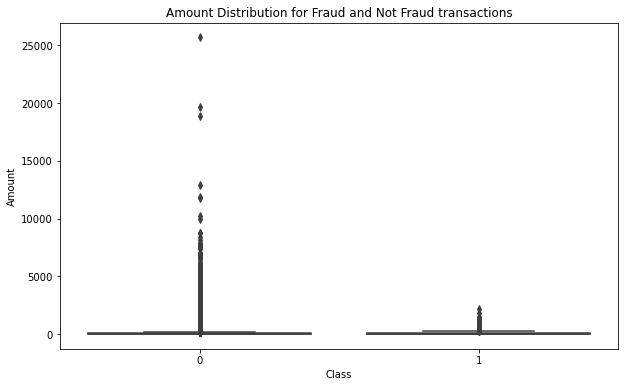

In [37]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Class', y='Amount',data = df)
plt.title('Amount Distribution for Fraud and Not Fraud transactions')
plt.show()

#### Insights

1. Class 1 represents fraudulent transaction while Class 0 represents genuine transactions. Majority of the genuine transactions involve amount of up to 3000. We can observe presence of a few outliers, these could be some expensive purchases made by the credit card user. We can remove these outliers, but we need to keep in mind here that these transactions could be fraudulent as well. Removing these could introduce bias in our predictive models.

## Distribution of Time

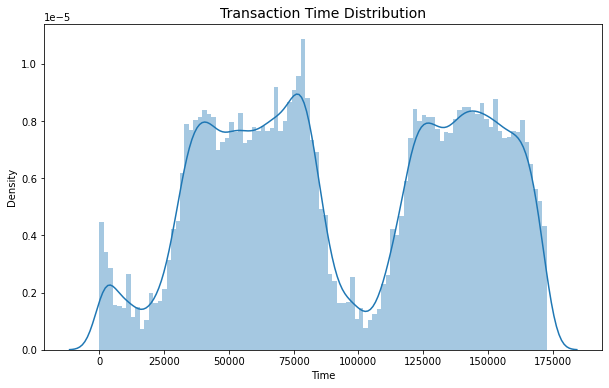

In [36]:
plt.figure(figsize=(10,6))
plt.title('Transaction Time Distribution', fontsize=14)
sns.distplot(df['Time'], bins=100)
plt.show()

#### Insights

There two significant peaks in the graph for time distribution and some other local peaks. These peaks can indicate the time of the day when most of the transaction were made, like during the daytime when most of the people made purchases. While the valleys could be nighttime when fewer transactions occured. As per the information of dataset we have the credit card transactions of only two days, as signified by the two peaks of daytime and one nighttime peak.

Let us have a closer look at the distribution of time by looking at different classes to better understand it.


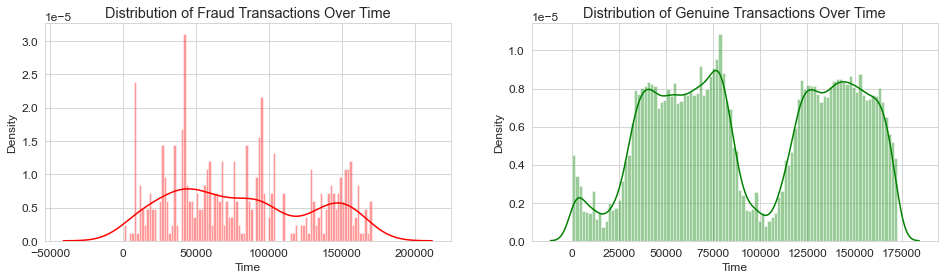

In [100]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(df[(df['Class'] == 1)]['Time'], bins=100, color='red', ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions Over Time")

sns.distplot(df[(df['Class'] == 0)]['Time'], bins=100, color='green', ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions Over Time")


plt.show()


#### Insights

1. Looking at the distribution of time with respect to classes, we can yet again identify the two peaks when majority of the transaction were made during the daytime in the plot for Genuine Transactions. 
2. In the fraudulent transaction distribution over time we do not see any such patterns. 

Let us further look at Distribution of time vs Amount to check if relations exist.


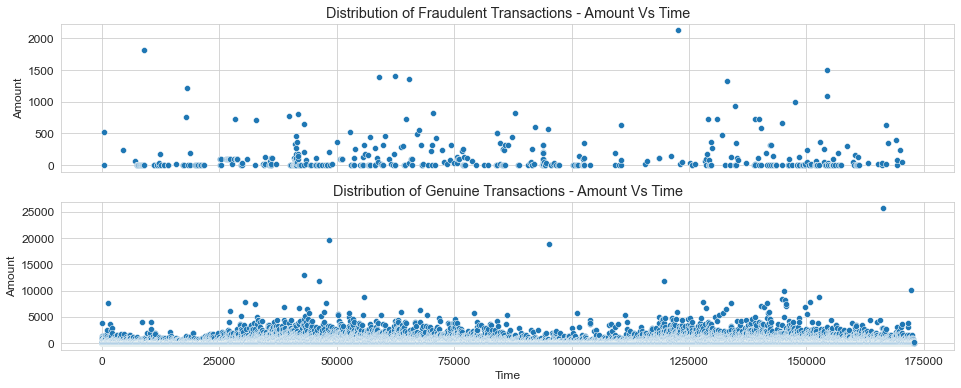

In [101]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(16,6))

sns.scatterplot(x='Time',y='Amount', data=df[df['Class']==1], ax=axs[0])
axs[0].set_title("Distribution of Fraudulent Transactions - Amount Vs Time")

sns.scatterplot(x='Time',y='Amount', data=df[df['Class']==0], ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions - Amount Vs Time")

plt.show()

#### Insights

1. The Fraudulent transactions vary between 0 to 2000 while the genuine transactions vary between 0 to 25000.
2. Genuine transactions have higher density between the amount 0 to 10000 with a few high value transactions, there also exists peaks along the x-axis which show transactions were made during particular time of the day.
3. Fraudulent transactions, on the other hand, show a lot of variations and do not display any apparent pattern for amount and time.

Let’s look at correlation amongst the variables.

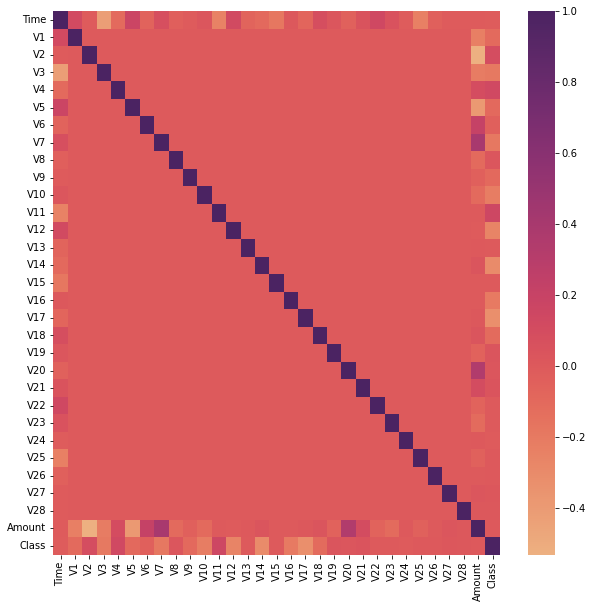

In [48]:
# heatmap to check for correlations
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), cmap="flare")
plt.show();

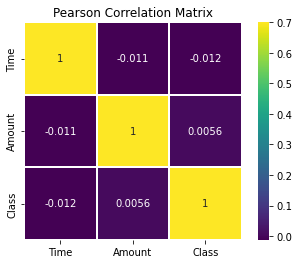

In [50]:
#Pearson correlation between Explanatory variable
plt.title('Pearson Correlation Matrix')
sns.heatmap(df[['Time', 'Amount','Class']].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="viridis",
            linecolor='w',annot=True);

#### Insights

1. From the correlation matrix we can see that the variables V1 to V28 (PCA components) are not correlated to each other. The class variable shows some extent of correlation with these variables, but no correlation exists with the V variables to time and amount.
2. The most correlation can be seen for explanatory variables Time, Amount and Class. However, even these variables are not highly correlated. Suggesting we do not need to worry about multicollinearity.

<Figure size 432x288 with 0 Axes>

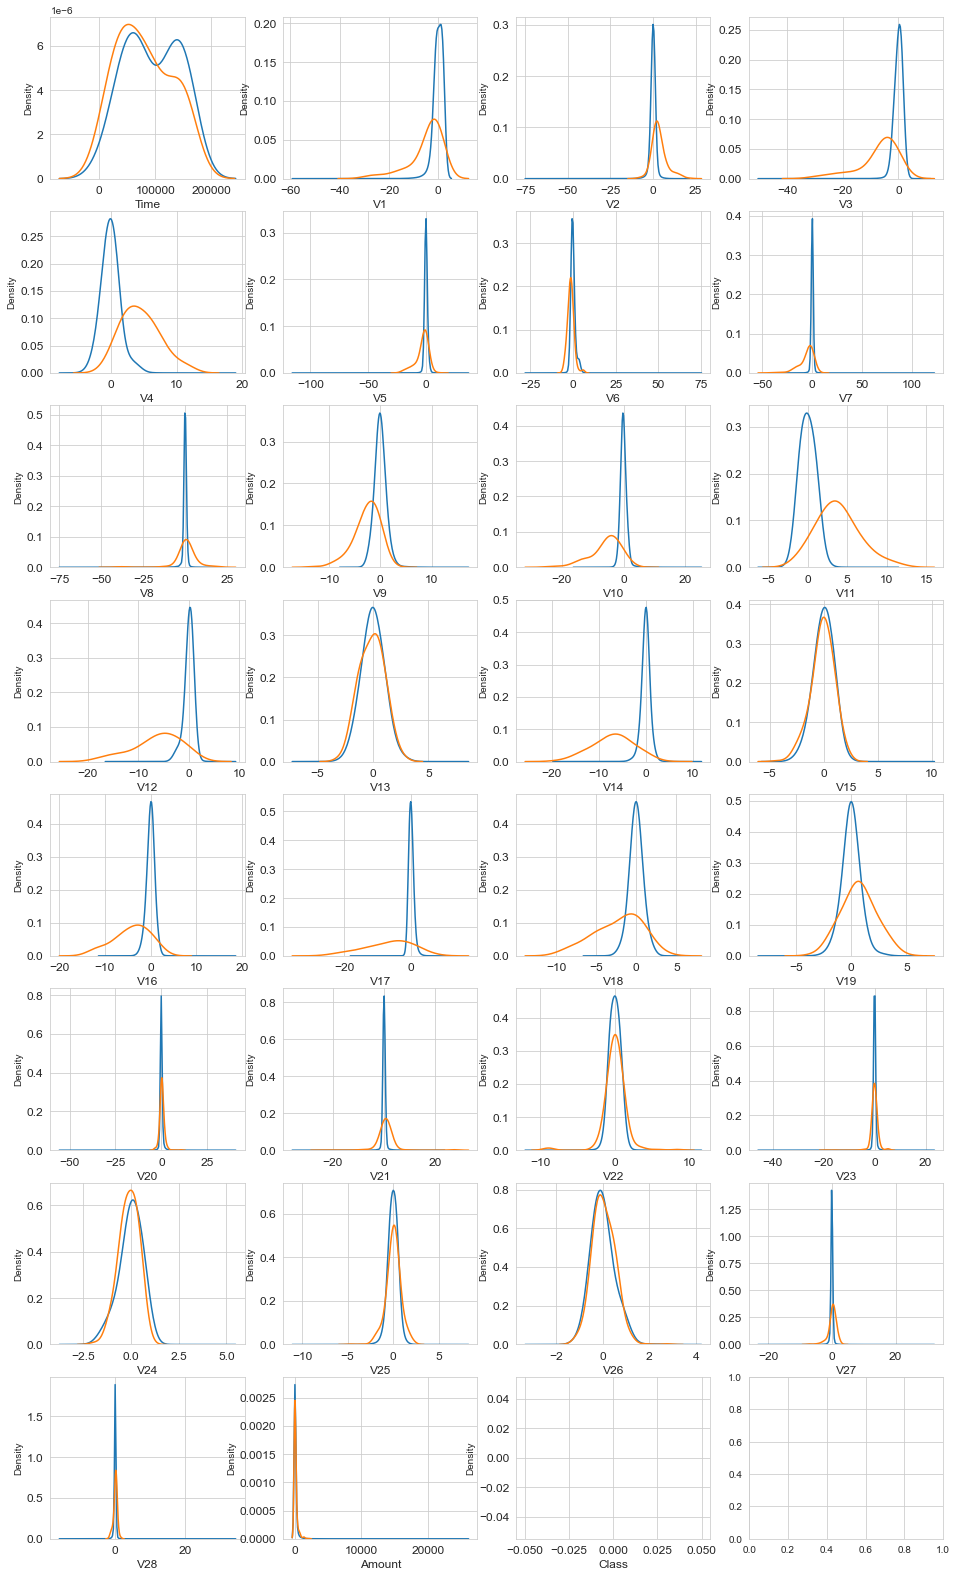

In [52]:
var = df.columns.values

k = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    k += 1
    plt.subplot(8,4,k)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

#### Insights

1. From the density plots,the fraudulent transactions have an asymmetric distribution. 
2. We can see the feature distribution for genuine transaction varies around zero, except for the time and amount variable. 

# Predictive Models

We will be training the following classifiers as our predictive models:

#### Selected Predictive models
1. Random Forest Classifiers
2. AdaBoost
3. CatBoost
4. XGBoost
5. LightGBM
6. Isolation Forest

#### Model Evaluation Metrics
1. Precision, recall, f1, accuracy
2. Confusion matrix
3. ROC - AUC

Decision trees, Random Forests, and algorithms based on tree ensembles, are generally invariant to feature scales since they make decisions based on feature thresholds. Hence, we do not need to scale our features.

Let us first define our predictor variables and the predicted or target feature:


In [60]:
# our traget variable is the feature class which contains 2 classes
X = df.drop(['Class'], axis = 1) 
y = df["Class"] 

In [58]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [61]:
#train test split on data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=101)

### 1. Random Forests

We are using randomforestclassifier and training it on the dataset. A commonly used machine learning algorithm, trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fuelled its adoption, as it handles both classification and regression problems [2].

We will be setting n-jobs to 4 (using 4 CPU cores), and we are using **Gini Impurity Criterion.** Gini impurity measures impurity of a split, which helps in evaluating if a subset after a split is pure (i.e. Gini impurity=0), decision tree or similar algorithms divides the features based on this output. The algorithm aims to minimize Gini impurity by selecting splits that maximize the purity of the resulting child nodes. 
It is used to guide the selection of optimal splits during the tree-building process. Gini impurity is computationally more efficient than Entropy.

If we have C classes and $p_{i}$ is probability of of picking a datapoint with class i, then the Gini Impurity is calculated as[3]-


Gini impurity = 1− $∑_{i=1}^{C}$ ​ $p_{i}^2$ ​ (1− $p_{i}$) 
                    
(Gini impurity is always between 0 and 0.5, max value = 0.5)



Which is summation of probabilities p.

Number of estimators (number of decision tress created in random forest)

In [138]:
clf1 = RandomForestClassifier(n_jobs=4, 
                             random_state=2000,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)

In [139]:
#fit the model
clf1.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4, random_state=2000, verbose=False)

In [140]:
#make prediction using predict function
preds_rf = clf1.predict(X_test)

#### Feature Importance for Random Forest

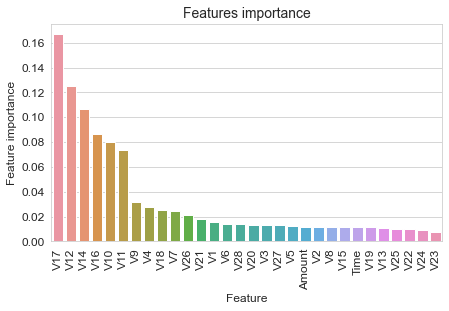

In [115]:
imp = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': clf1.feature_importances_})
imp = imp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=imp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The most important features for the random forest model are V17, V12, V14.

### Model Evaluation

In [465]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

#### Classifiaction report : Precision, Recall, f1-Score, Accuracy

Let’s get acquainted with the terminology first. 

A confusion matrix is a matrix that summarizes the performance of a machine learning model on a set of test data [4]. It is divided into 4 parts. 

**True Positive (TP)** - Number of samples of positive class correctly classified as positive by model. Truly positive.  
**False Positive (FP)** - Number of samples of negative class incorrectly classified as positive by model. Were actually false.
**True Negative (TN)** - Number of samples of negative class correctly classified as negative by model. Truly negative.
**False Negative (FN)** - Number of samples of negative class incorrectly classified as negative by model. Were actually positive.

**Precision:** What percent of predictions made were correct? That is correct positive prediction divide by total positive predictions made.

$$
Precision = \frac{TP}{TP + FP}\
$$

**Recall:** What percent of actually positive values were correctly classified by the classifier? That is correctly predicted as true divided by total positive observations (includes observations which were true but model couldn't identify as true). Out of total positive observations how many observations the model could correctly classify as true.

$$
Recall = \frac{TP}{TP + FN}\
$$

**Accuracy:** What percent of predictions were accurately made by the model? That is out of all observations (positive and negative) how many observations were correctly identified by the model i.e. True positives and True negatives.

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}\
$$

**F1 Score:** F1 score is harmonic mean of precision and recall, that means if precision and recall ***both*** are high then F1 is high, if both are low - F1 is low. F1 is usually used when we are comparing different models.

$$
F1 Score = \frac{2 * precision * recall}{precision + recall}\
$$
or,

$$
F1 Score = \frac{TP}{TP + \frac{1}{2}\,(FP + FN)}\
$$

In [141]:
print(metrics.classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.96      0.83      0.89       103

    accuracy                           1.00     56962
   macro avg       0.98      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



In [480]:
print("Highlights: ")

acc1 = accuracy_score(y_test, preds_rf) 
print("The accuracy is {}".format(acc1)) 
  
prec = precision_score(y_test, preds_rf) 
print("The precision is {}".format(prec)) 
  
rec_rf = recall_score(y_test, preds_rf) 
print("The recall is {}".format(rec_rf)) 
  
f1_rf = f1_score(y_test, preds_rf) 
print("The F1-Score is {}".format(f1_rf)) 

#print('The AUC-ROC score is {} '.format(auc))

Highlights: 
The accuracy is 0.9996313331694814
The precision is 0.9555555555555556
The recall is 0.8349514563106796
The F1-Score is 0.8911917098445595


#### Confusion Matrix

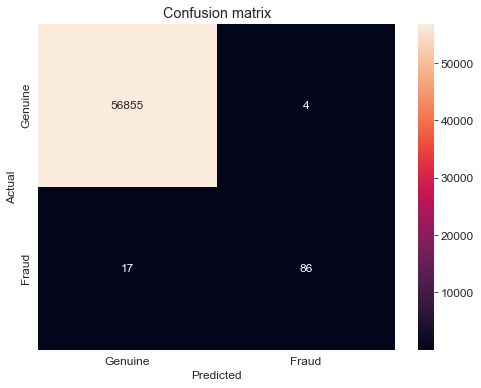

In [143]:
LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, preds_rf) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

In [111]:
86/144 #correctly identified fraud from the total fraudulent transactions

0.5972222222222222

#### Insights
In a confusion matrix,

- **True Positive -** Is positive and was classified as positive by the predictive model. Our model was able to correctly recognise 56855 genuine transactions as genuine.
- **False Positive -** Is positive and was classified as negative incorrectly. Our model incorrectly identified 4 legitimate transactions as fraud.
- **True Negative -** Is Negative and was correctly classified as negative by the model. Our model was able to correctly identify 86 fraudulent transaction which were originally labelled as fraud.
- **False Negative**- Is negative but was classified as positive by model. Our model incorrectly classified 17 transactions which were originally fraud as genuine transactions [4].

*ref - Confusion matrix in machine learning - https://www.geeksforgeeks.org/confusion-matrix-machine-learning/*

**86** transactions were identified as fraudulent out of total 144 fraud and **56856** as normal transactions by our model correctly.

This shows the accuracy of our model to **predict fraudulent transaction is 86/144** i.e. **0.59**

confusion matrix is not the best evaluation metric hence we will look at ROC-AUC.

#### Area Under the Curve (AUC) and Receiver Operating Characteristic (ROC)

AUC and ROC are effective evaluation metrics. 

**Receiver Operating Characteristic or ROC** show how well the model has performed and how is it making decisions at various certainty levels(thresholds). The threshold level has been specified for a given value for Confusion matrix, recall, precision, and accuracy scores. So, ROC provides a more robust solution to evaluate classification models by plotting a probability curve at various threshold values [6]. ROC creates a **TPR**(True Positive Rate) VS **FPR**(False Positive Rate) at different classification thresholds.

**True Positive Rate (Sensitivity)** is a synonym for is a synonym for recall and is therefore defined as follows [7]:

Proportion of actual positives identified correctly as positives.

$$ 
TPR = \frac{True Positive}{True Positive + False Negative}\
$$

**False Positive Rate (FPR)** is defined as follows [7]:

Proportion of actual negatives classified as positive by model. 

$$
FPR = \frac{False Positive}{False Positive + True Negative}\
$$



<img src=https://developers.google.com/static/machine-learning/crash-course/images/ROCCurve.svg width="300">
*Src:https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc*

**Area Under the Curve or AUC** stands for the are under the ROC. This metric tells us how well the classifier was able to distinguish between classes and it is used as a summary of the ROC curve [6]. The total area under the curve is 1. So, the closer the AUC is to 1 the better is the model performance. Essentially, if AUC = 1, then it means that the model was able to correctly differentiate between all positive and negative classes. On the other hand, if AUC = 0, it means the model incorrectly classified all samples for both classes i.e. it predicted all Negative samples as positive samples and all positive samples as negative samples.

<img src=https://developers.google.com/static/machine-learning/crash-course/images/AUC.svg width="300">
*Src:https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc*

ROC-AUC score  -  0.9174405534248661 



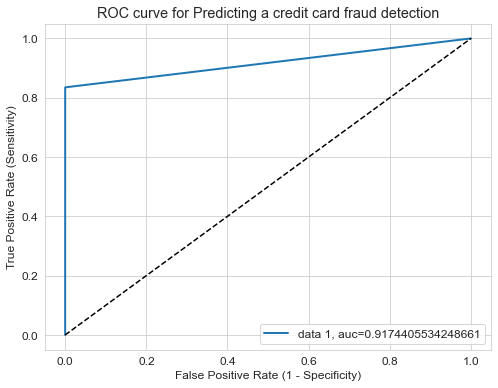

In [255]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr1, tpr1, thresholds = metrics.roc_curve(y_test, preds_rf)

auc = metrics.roc_auc_score(y_test, preds_rf)
print("ROC-AUC score  - ",auc,"\n")

plt.plot(fpr1,tpr1,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

**The ROC-AUC score obtained for Random Forest is - 0.91**

## 2. AdaBoost Classifier

AdaBoost is short for Adaptive Boosting is an ensemble machine learning algorithm [8]. It comes under the umbrella of supervised machine learning algorithms. This algorithm combines multiple weak learners usually decision trees with 1 level to create a strong classifier. As in boosting techniques, it builds multiple models that correct the faults of previous one. 

AdaBoost classifier, builds multiple decision trees with depth=1, initially it assigns equal weights to all datapoints in the first model and then at each iteration it assigns higher weights to the misclassified data points, then these (miscalssified)data points with higher weights go to the next model and the new model now assigns higher weights to these datapoints so the new model focuses more on these samples thereby gradually minimising the error. It keeps on training models until a smaller error rate is achieved.

In [158]:
clf2 = AdaBoostClassifier(random_state=2018,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=100)

In [159]:
#fit the model
clf2.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [160]:
#make prediction using predict function
preds_ada = clf2.predict(X_test)

#### Feature Importance for Random Forest

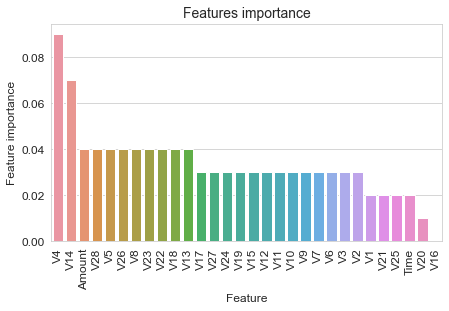

In [161]:
imp = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': clf2.feature_importances_})
imp = imp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=imp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The most important features for the Adaboost classifier are V4, V14 and amount. Which are quite different than random forest

#### Model Evaluation

#### Classification Report

In [162]:
print(metrics.classification_report(y_test, preds_ada))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.90      0.73      0.81       103

    accuracy                           1.00     56962
   macro avg       0.95      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [479]:
acc2 = accuracy_score(y_test, preds_ada) 
print("The accuracy is {}".format(acc2)) 
  
prec = precision_score(y_test, preds_ada) 
print("The precision is {}".format(prec)) 
  
rec_ada = recall_score(y_test, preds_ada) 
print("The recall is {}".format(rec_ada)) 
  
f1_ada = f1_score(y_test, preds_ada) 
print("The F1-Score is {}".format(f1_ada)) 

The accuracy is 0.9993679997191109
The precision is 0.9036144578313253
The recall is 0.7281553398058253
The F1-Score is 0.8064516129032259


#### Confusion Matrix

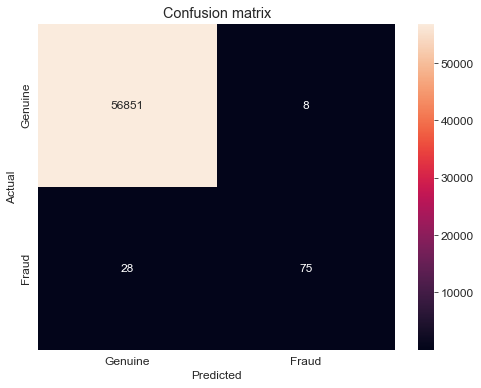

In [164]:
LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, preds_ada) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

In [165]:
75/144 #correctly identified fraud from the total fraudulent transactions

0.5208333333333334

#### Insights

1. **75** transactions were recognised as fraudulent out of total 144 frauds and **56856** as normal transactions by our model correctly. This shows the accuracy of our model to predict fraudulent transaction is **75/144** i.e. **0.52**
2. There are 8 transactions that were genuine but were identified as fraud. 
3. 28 fraudulent transactions were identified as genuine.

#### Area Under the Curve (AUC) and Receiver Operating Characteristic (ROC)

ROC-AUC score  -  0.8640073204419654 



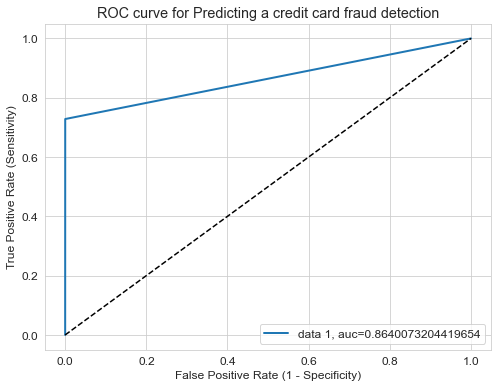

In [254]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, preds_ada)

auc_ada = metrics.roc_auc_score(y_test, preds_ada)
print("ROC-AUC score  - ",auc_ada,"\n")

plt.plot(fpr2,tpr2,linewidth=2, label="data 1, auc="+str(auc_ada))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

**The ROC-AUC score obtained for AdaBoost Classifier is - 0.86**


## 3. XGBoost

XGBoost, short for EXtreme Gradient Boosting is another ensemble supervised machine learning algorithm. It iteratively creates decision trees, where each new tree corrects the errors made by the previous ones. This algorithm is quite efficient and has high accuracy score. XGB is highly efficient and faster than other gradient boosting machines and random forests.

In [176]:
# Convert data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [177]:
# Set xgboost parameters
'''params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = 2000'''

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',           # Evaluation metric
    'max_depth': 3,                   # Maximum depth of each tree
    'eta': 0.039,                       # Learning rate
    'gamma': 0.1,                     # Minimum loss reduction required to make further partition
    'subsample': 0.8,                 # Subsample ratio of the training instances
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 42                        # Random seed for reproducibility
}

In [178]:
# Train the XGBoost model
num_round = 100  # Number of boosting rounds

#xgb_model = xgb.train(params, dtrain, num_round)
xgb_model = xgb.train(params, 
                dtrain, 
                num_round,   
                maximize=True, 
                verbose_eval=50)

In [179]:
# Make predictions
preds_xg = xgb_model.predict(dtest)

In [180]:
# Convert predicted probabilities to binary predictions
binary_preds_xg = [1 if pred > 0.5 else 0 for pred in preds_xg]

#### Feature Importance

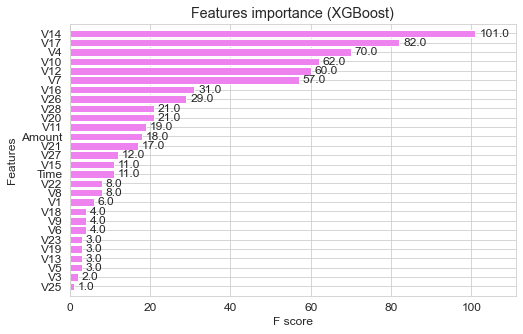

In [191]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xgb_model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="violet") 
plt.show()

The most important features are V14, V17, V4 and V10.

#### Model Evaluation

#### Classification Report

In [202]:
print(metrics.classification_report(y_test, binary_preds_xg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.92      0.83      0.87       103

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [478]:
acc3 = accuracy_score(y_test, binary_preds_xg) 
print("The accuracy is {}".format(acc3)) 
  
prec = precision_score(y_test, binary_preds_xg) 
print("The precision is {}".format(prec)) 
  
rec_xg = recall_score(y_test, binary_preds_xg) 
print("The recall is {}".format(rec_xg)) 
  
f1_xg = f1_score(y_test, binary_preds_xg) 
print("The F1-Score is {}".format(f1_xg)) 

The accuracy is 0.9995611109160493
The precision is 0.9239130434782609
The recall is 0.8252427184466019
The F1-Score is 0.8717948717948718


#### Confusion Matrix

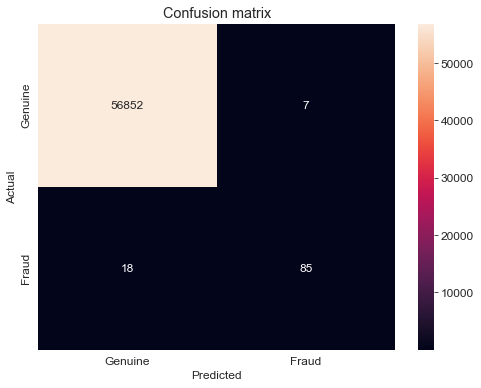

In [187]:
LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, binary_preds_xg) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

In [189]:
85/144 #correctly identified fraud from the total fraudulent transactions

0.5902777777777778

#### Insights

1. **85** transactions were correctly recognised as fraudulent out of a total of 144 fraud transactions and **56856** as normal transactions by our model correctly. This shows the accuracy of our model to predict fraudulent transaction is **85/144** i.e., **0.59**
2. There are 7 transactions that were genuine but were identified as fraud. 
3. 18 fraudulent transactions were identified as Genuine.

#### Area Under the Curve (AUC) and Receiver Operating Characteristic (ROC)

ROC-AUC score  -  0.9576696023906522 



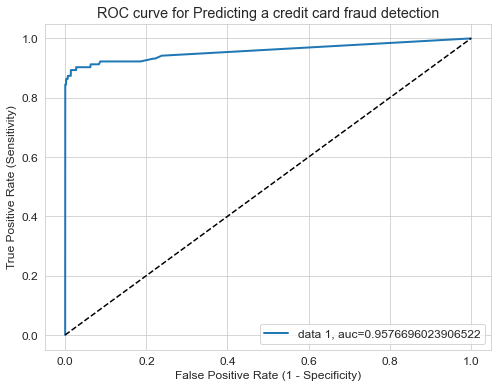

In [253]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr3, tpr3, thresholds = metrics.roc_curve(y_test, preds_xg)

auc_xg = metrics.roc_auc_score(y_test, preds_xg)
print("ROC-AUC score  - ",auc_xg,"\n")

plt.plot(fpr3,tpr3,linewidth=2, label="data 1, auc="+str(auc_xg))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

**The ROC-AUC score obtained for XGBoost Classifier is - 0.95**

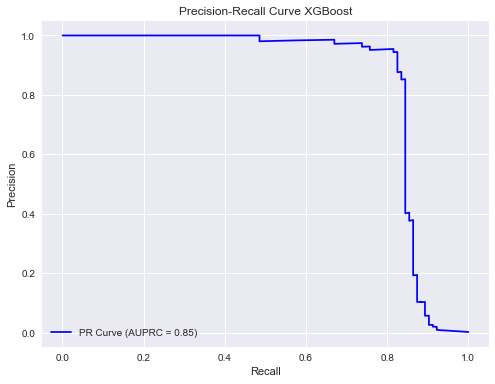

In [423]:
precision, recall, _ = precision_recall_curve(y_test, preds_xg)
auprc = average_precision_score(y_test, preds_xg)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve XGBoost')
plt.legend()
plt.show()



## 4. CatBoost
CatBoost is gradient boosting algorithm with the ability to handle categorical data without any need of label encoding. 

In [195]:
clf3 = CatBoostClassifier(iterations=100,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 2019,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100)

In [197]:
#fit the model
clf3.fit(X_train, y_train)

0:	total: 514ms	remaining: 50.9s
50:	total: 25.4s	remaining: 24.4s
99:	total: 47.7s	remaining: 0us


In [198]:
#make prediction using predict function
preds_cat = clf3.predict(X_test)

#### Feature Importance for CatBoost

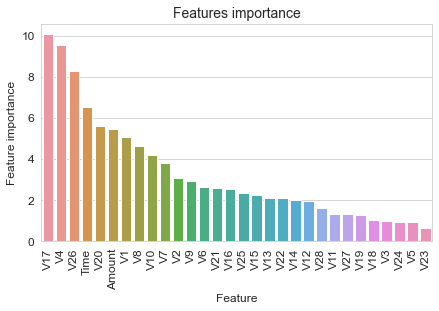

In [199]:
imp = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': clf3.feature_importances_})
imp = imp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=imp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The most important features for the CatBoost classifier are V17, V4, V26 and Time. 

### Model Evaluation

#### Classification Report

In [201]:
print(metrics.classification_report(y_test, preds_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.99      0.82      0.89       103

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



In [475]:
acc4 = accuracy_score(y_test, preds_cat) 
print("The accuracy is {}".format(acc4)) 
  
prec = precision_score(y_test, preds_cat) 
print("The precision is {}".format(prec)) 
  
rec_cat = recall_score(y_test, preds_cat) 
print("The recall is {}".format(rec_cat)) 
  
f1_cat = f1_score(y_test, preds_cat) 
print("The F1-Score is {}".format(f1_cat)) 

The accuracy is 0.9996488887328394
The precision is 0.9882352941176471
The recall is 0.8155339805825242
The F1-Score is 0.8936170212765956


#### Confusion Matrix

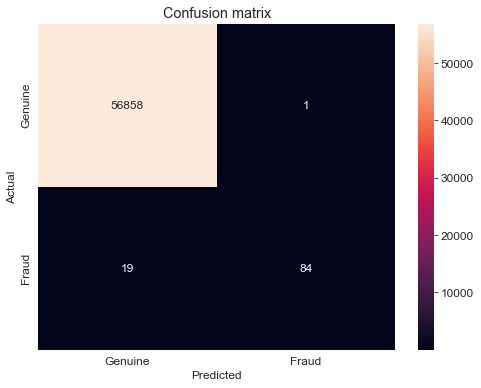

In [203]:
LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, preds_cat) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

In [204]:
84/144 #correctly identified fraud from the total fraudulent transactions

0.5833333333333334

#### Insights

1. **84** transactions were correctly recognised as fraudulent out of a total of 144 fraud transactions and **56858** as normal transactions by our model correctly. This shows the accuracy of our model to predict fraudulent transaction is **86/144** i.e., **0.59**
2. Only 1 genuine transaction was incorrectly identified as fraud. 
3. 19 fraudulent transactions were identified as Genuine.

#### Area Under the Curve (AUC) and Receiver Operating Characteristic (ROC)

ROC-AUC score  -  0.9077581966086438 



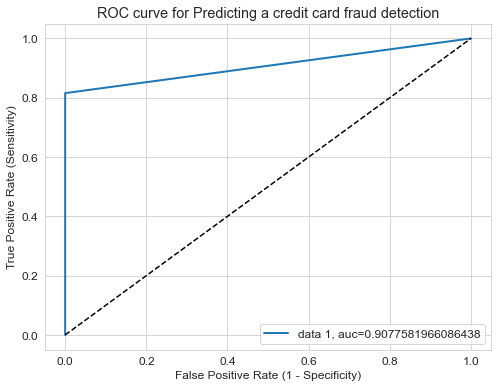

In [252]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr4, tpr4, thresholds = metrics.roc_curve(y_test, preds_cat)

auc_ct = metrics.roc_auc_score(y_test, preds_cat)
print("ROC-AUC score  - ",auc_ct,"\n")

plt.plot(fpr4,tpr4,linewidth=2, label="data 1, auc="+str(auc_ct))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

**The ROC-AUC score obtained for CatBoost Classifier is - 0.91**

## 5. LightGBM

LightGBM was developed by microsoft. LightGBM trains decision trees leaf-wise. [9]


In [212]:

# Define parameters for LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',  # Evaluation metric
    'num_leaves': 7,           # Maximum number of leaves in one tree
    'learning_rate': 0.05,       # Learning rate
    'max_depth': 4,              
    'min_child_samples': 100,   # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100, 
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7, 
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 8,
    'feature_fraction': 0.8,    # Percentage of features to consider for each tree
    'bagging_fraction': 0.8,    # Percentage of data to use for each iteration
    'bagging_freq': 5,          # Frequency for bagging
    'verbose': 0                # Verbosity
}

In [213]:
# Convert data to LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [243]:
# Train the LightGBM model
num_round = 50 # Number of boosting rounds
lgb_model = lgb.train(params, 
                      train_data, 
                      num_round, 
                      valid_sets=[test_data], 
                      feval=None)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 

In [244]:
# Make predictions
preds_lgb = lgb_model.predict(X_test)
y_predlgb = [1 if pred > 0.5 else 0 for pred in preds_lgb]

#### Feature Importance

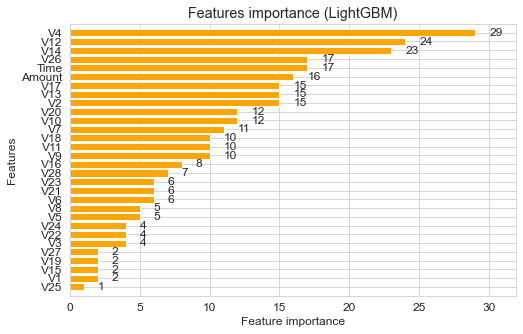

In [245]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(lgb_model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="orange") 
plt.show()

The most important features for the LightGBM classifier are V4, V12, and Amount

#### Model Evaluation

#### Classification Report

In [246]:
print(metrics.classification_report(y_test, y_predlgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.88      0.78      0.82       103

    accuracy                           1.00     56962
   macro avg       0.94      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [482]:
acc5 = accuracy_score(y_test, y_predlgb) 
print("The accuracy is {}".format(acc5)) 
  
prec = precision_score(y_test, y_predlgb) 
print("The precision is {}".format(prec)) 
  
rec_lg = recall_score(y_test, y_predlgb) 
print("The recall is {}".format(rec_lg)) 
  
f1_lg = f1_score(y_test, y_predlgb) 
print("The F1-Score is {}".format(f1_lg)) 

The accuracy is 0.999403110845827
The precision is 0.8791208791208791
The recall is 0.7766990291262136
The F1-Score is 0.824742268041237


#### Confusion Matrix

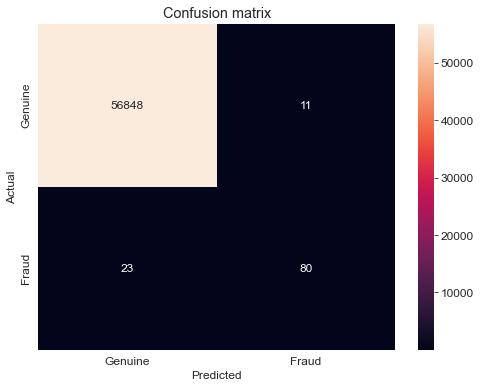

In [248]:
LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, y_predlgb) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

In [249]:
= 80/144 #correctly identified fraud from the total fraudulent transactions

0.5555555555555556

#### Insights

1. **80** transactions were correctly recognised as fraudulent out of a total of 144 fraud transactions and **56848** as normal transactions by our model correctly. This shows the accuracy of our model to predict fraudulent transaction is **80/144** i.e. **0.55**
2. There are 11 transactions that were genuine but were identified as fraud. 
3. 23 fraudulent transactions were identified as Genuine.


#### Area Under the Curve (AUC) and Receiver Operating Characteristic (ROC)

ROC-AUC score  -  0.9722832515179349 



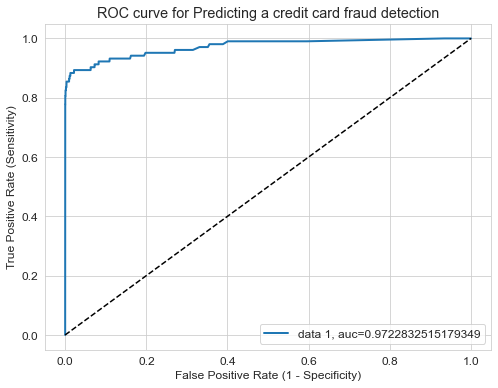

In [251]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr5, tpr5, thresholds = metrics.roc_curve(y_test, preds_lgb)

auc_lg = metrics.roc_auc_score(y_test, preds_lgb)
print("ROC-AUC score  - ",auc_lg,"\n")

plt.plot(fpr5,tpr5,linewidth=2, label="data 1, auc="+str(auc_lg))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

**The ROC-AUC score obtained for LighGBM Classifier is - 0.97**

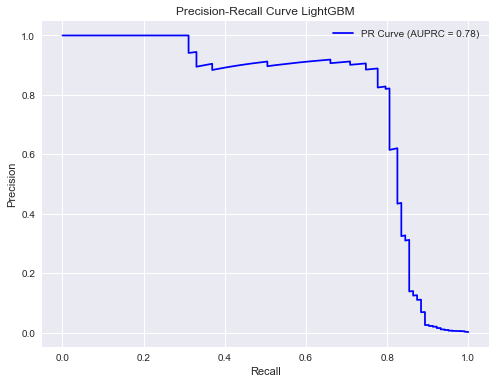

In [424]:
precision, recall, _ = precision_recall_curve(y_test, preds_lgb)
auprc = average_precision_score(y_test, preds_lgb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve LightGBM')
plt.legend()
plt.show()

## Compare Models

Here is a comparison of models with imbalanaced classes.

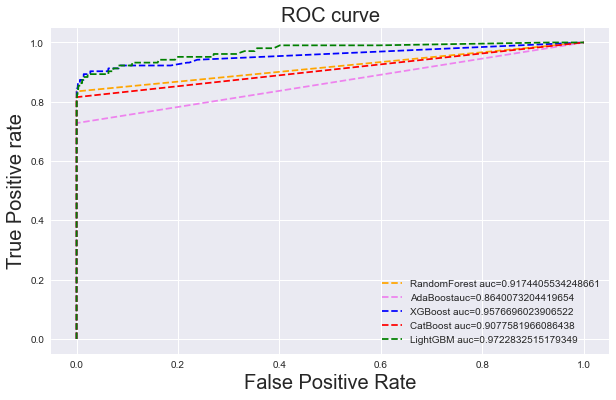

In [320]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(10,6))

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='RandomForest auc='+str(auc))
plt.plot(fpr2, tpr2, linestyle='--',color='violet', label='AdaBoostauc='+str(auc_ada))
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='XGBoost auc='+str(auc_xg))
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='CatBoost auc='+str(auc_ct))
plt.plot(fpr5, tpr5, linestyle='--',color='green', label='LightGBM auc='+str(auc_lg))
# title
plt.title('ROC curve', fontsize=20)
# x label
plt.xlabel('False Positive Rate', fontsize=20)
# y label
plt.ylabel('True Positive rate', fontsize=20)

plt.legend(loc='best')
plt.show()

#### Insights
1. The best auc-roc score was achieved by, LightGBM **0.97**, followed by xgboost -**0.95**. 

In [274]:
print('Random Forest- Accuracy:', acc1 ,'AUC:', auc)
print('AdaBoost - Accuracy:', acc2 ,'AUC:', auc_ada)
print('CatBoost - Accuracy:', acc4 ,'AUC:', auc_ct)
print('XGBoost - Accuracy:', acc3 ,'AUC:', auc_xg)
print('LightGBM - Accuracy:', acc5 ,'AUC:', auc_lg)

Random Forest- Accuracy: 0.9996313331694814 AUC: 0.9174405534248661
AdaBoost - Accuracy: 0.9993679997191109 AUC: 0.8640073204419654
CatBoost - Accuracy: 0.9996488887328394 AUC: 0.9077581966086438
XGBoost - Accuracy: 0.9995611109160493 AUC: 0.9576696023906522
LightGBM - Accuracy: 0.999403110845827 AUC: 0.9722832515179349


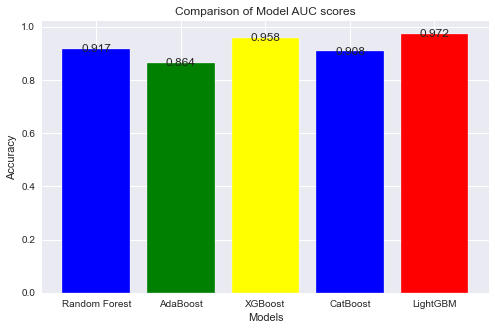

In [493]:
# Plotting the comparison
models = ['Random Forest', 'AdaBoost', 'XGBoost', 'CatBoost', 'LightGBM']
auc_scores2 = [auc, auc_ada, auc_xg, auc_ct, auc_lg]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, auc_scores2, color=['blue', 'green', 'yellow', 'blue', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model AUC scores')


# Annotate bars with accuracy values
for bar, auc in zip(bars, auc_scores2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{auc:.3f}', ha='center', va='bottom')

plt.show()

We have achieved remarkably high accuracies in the models, and high auc scores. It is important to note that a good auc-roc score does not necessarily mean a good precision-recall score. We will calculate Area under Precision -recall curve (AUPRC) score to get more accurate results (later). These metrics could be misleading due to bias introduced by imbalanced classes. 


# Imbalanced Class

Class imbalance occurs in a classification problem when the instances in the class variable are unevenly distributed. Class imbalance is a classic issue especially in real-world data. Class imbalance could induce bias in machine learning models as models tend to be biased towards the majority class which leads to inferior performance and inefficiency for minority class. Hence, standard error metrics like accuracy could be misleading, as the models are able to achieve high accuracy by simply predicting majority class all the time. 

The classes of our chosen dataset are highly imbalance. And as shown in the above bar plot our models achieved very high accuracies. Let’s address the class imbalance issue and check how these change. To do this we will use following techniques:

1. **SMOTE**
2. **ADASYN**

Due to very few instances of minority class in an imbalanced classification problem, the model is unable to effectively learn the decision boundaries [10]. To overcome this issue, we can duplicate the examples from the minority class, that is oversample the minority class in the training dataset before fitting the predictive models. This creates evenly distributed classes at the same time the model won’t get any new information from the data we introduced as it was duplicated. 

**Synthetic Minority Oversampling Technique (SMOTE):** SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line [10]. 

SMOTE takes a randomly selected instance from the minority class and then finds the K-nearest neighbours for this sample. Out these selected neighbours, one is chosen at random to synthesis new data by interpolating between selected instance and the selected neighbour [11].
One potential drawback of SMOTE is that it may generate noisy samples if the feature space is not well-defined or if there are overlapping regions between classes [10].

**Adaptive Synthetic Sampling (ADASYN):** ADASYN is another technique to handle imbalanced classes, it is an extension of SMOTE. Unlike SMOTE instead of generating copy of same instance of minority class, it generates more synthetic samples for minority class instances that are harder to classify [11].



In [331]:
#import libraries
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#### Random Forest With SMOTE

In [329]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(227845,)

In [332]:
#check data
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_smote))

Original dataset shape Counter({0: 227456, 1: 389})
Resampled dataset shape Counter({0: 227456, 1: 227456})


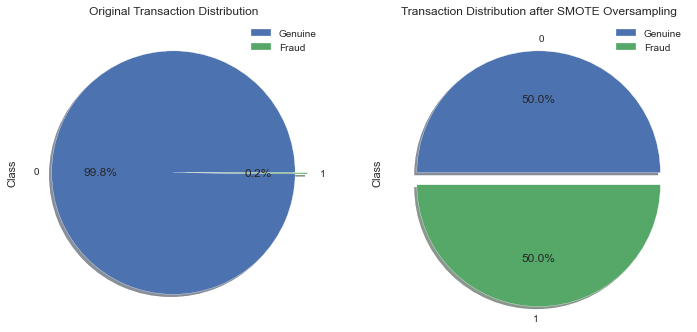

In [399]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original Data
df["Class"].value_counts().plot(kind='pie', explode=[0, 0.1], ax=axs[0], autopct='%1.1f%%', shadow=True)
axs[0].set_title("Original Transaction Distribution")
axs[0].legend(["Genuine", "Fraud"])

# Data after SMOTE oversampling
y_train_smote.value_counts().plot(kind='pie', explode=[0, 0.1], ax=axs[1], autopct='%1.1f%%', shadow=True)
axs[1].set_title("Transaction Distribution after SMOTE Oversampling")
axs[1].legend(["Genuine", "Fraud"])

plt.show()

In [334]:
# SMOTE Sampling with Random Forest
# Train the classifier
clf1.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_jobs=4, random_state=2000, verbose=False)

In [335]:
rf_pred_smote = clf1.predict(X_test)

#### Random Forest With ADASYN

In [343]:
adasyn = ADASYN(random_state=42)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)


In [344]:
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_adasyn))

Original dataset shape Counter({0: 227456, 1: 389})
Resampled dataset shape Counter({1: 227498, 0: 227456})


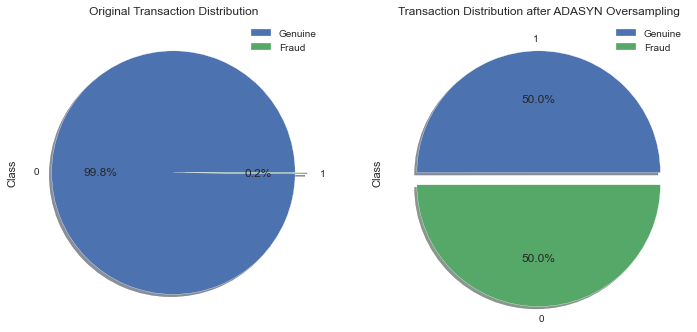

In [491]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original Data
df["Class"].value_counts().plot(kind='pie', explode=[0, 0.1], ax=axs[0], autopct='%1.1f%%', shadow=True)
axs[0].set_title("Original Transaction Distribution")
axs[0].legend(["Genuine", "Fraud"])

# Data after SMOTE oversampling
y_train_adasyn.value_counts().plot(kind='pie', explode=[0, 0.1], ax=axs[1], autopct='%1.1f%%', shadow=True)
axs[1].set_title("Transaction Distribution after ADASYN Oversampling")
axs[1].legend(["Genuine", "Fraud"])

plt.show()

In [345]:
# ADASYN Sampling with Random Forest
# Train the classifier
clf1.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(n_jobs=4, random_state=2000, verbose=False)

In [347]:
rf_pred_adasyn = clf1.predict(X_test)

#### Model Evaluation

#### Classification Report

In [474]:
print('Random Forest with SMOTE:')
acc11 = accuracy_score(y_test, rf_pred_smote) 
print("The accuracy is {}".format(acc11)) 
  
prec = precision_score(y_test, rf_pred_smote) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_test, rf_pred_smote) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_test, rf_pred_smote) 
print("The F1-Score is {}".format(f1)) 
print("\n")
print('Random Forest with ADASYN:')
acc12 = accuracy_score(y_test, rf_pred_adasyn) 
print("The accuracy is {}".format(acc12)) 
  
prec = precision_score(y_test, rf_pred_adasyn) 
print("The precision is {}".format(prec)) 
  
rec_rf_bal = recall_score(y_test, rf_pred_adasyn) 
print("The recall is {}".format(rec_rf_bal)) 
  
f1_rf_bal = f1_score(y_test, rf_pred_adasyn) 
print("The F1-Score is {}".format(f1_rf_bal)) 


Random Forest with SMOTE:
The accuracy is 0.9995611109160493
The precision is 0.90625
The recall is 0.8446601941747572
The F1-Score is 0.8743718592964823


Random Forest with ADASYN:
The accuracy is 0.9995786664794073
The precision is 0.9157894736842105
The recall is 0.8446601941747572
The F1-Score is 0.8787878787878788


#### Confusion Matrix

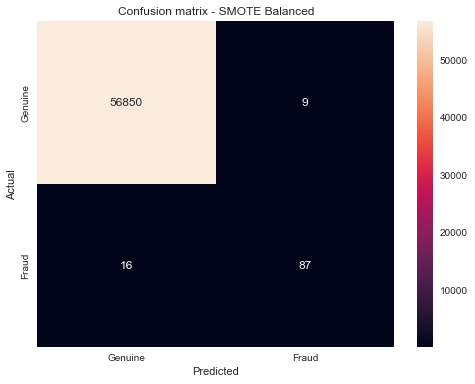

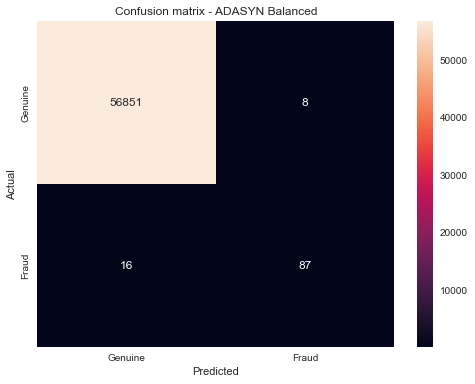

In [357]:
LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, rf_pred_smote) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix - SMOTE Balanced") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

LABELS = ['Genuine', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, rf_pred_adasyn) 
plt.figure(figsize =(8,6)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix - ADASYN Balanced") 
plt.ylabel('Actual') 
plt.xlabel('Predicted') 
plt.show() 

ROC-AUC score  -  0.9222509539438131 



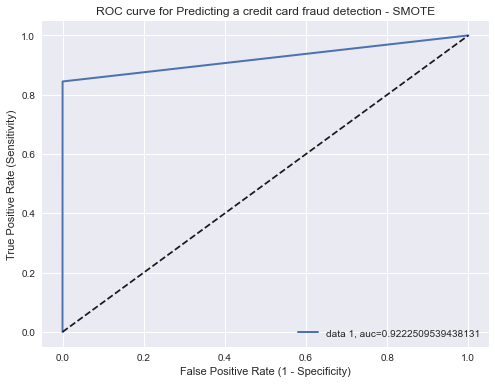

In [358]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr11, tpr11, thresholds = metrics.roc_curve(y_test, rf_pred_smote)

auc_rf_SMOTE = metrics.roc_auc_score(y_test, rf_pred_smote)
print("ROC-AUC score  - ",auc_rf_SMOTE,"\n")

plt.plot(fpr11,tpr11,linewidth=2, label="data 1, auc="+str(auc_rf_SMOTE))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection - SMOTE')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC-AUC score  -  0.9222597476264314 



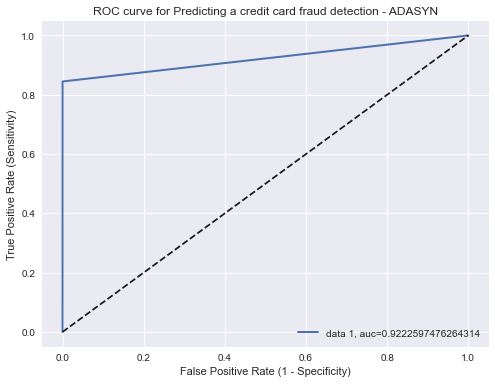

In [498]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr111, tpr111, thresholds = metrics.roc_curve(y_test, rf_pred_adasyn)

auc_rf_ADASYN = metrics.roc_auc_score(y_test, rf_pred_adasyn)
print("ROC-AUC score  - ",auc_rf_ADASYN,"\n")

plt.plot(fpr111,tpr111,linewidth=2, label="data 1, auc="+str(auc_rf_ADASYN))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection - ADASYN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

Since we are getting similar results with ADASYN and SMOTE we will continue with only ADASYN.

#### ADASYN sampling  LightGBM

In [435]:
# Apply ADASYN oversampling to the training data
#adasyn = ADASYN(random_state=42)
#X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, random_state=42)

# Train the classifier on the resampled training data
lgb_classifier.fit(X_train_adasyn, y_train_adasyn)

# Predict probabilities on the test set
lg_pred_adasyn = lgb_classifier.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 227498, number of negative: 227456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454954, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500046 -> initscore=0.000185
[LightGBM] [Info] Start training from score 0.000185


In [468]:
lg_pred_binary = (lg_pred_adasyn > 0.5).astype(int)  # Convert probabilities to binary predictions

In [473]:
print('LightGBM with ADASYN:')
acc21 = accuracy_score(y_test, lg_pred_binary) 
print("The accuracy is {}".format(acc12)) 
  
prec = precision_score(y_test, lg_pred_binary) 
print("The precision is {}".format(prec)) 
  
rec_lg_bal = recall_score(y_test, lg_pred_binary) 
print("The recall is {}".format(rec_lg_bal)) 
  
f1_lg_bal = f1_score(y_test, lg_pred_binary) 
print("The F1-Score is {}".format(f1_lg_adasyn))

LightGBM with ADASYN:
The accuracy is 0.9995786664794073
The precision is 0.6692913385826772
The recall is 0.8252427184466019
The F1-Score is 0.7391304347826086


#### Area under ROC

ROC-AUC score  -  0.9579137764905421 



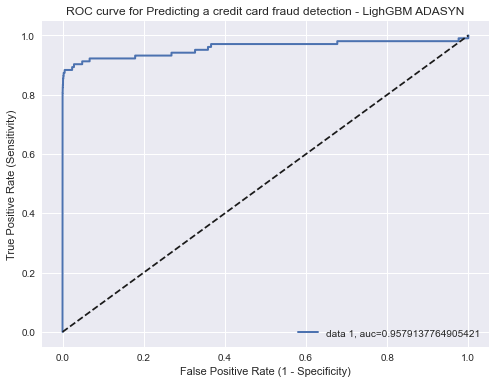

In [497]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr555, tpr555, thresholds = metrics.roc_curve(y_test, lg_pred_adasyn)

auc_lg_ADASYN = metrics.roc_auc_score(y_test, lg_pred_adasyn)
print("ROC-AUC score  - ",auc_lg_ADASYN,"\n")

plt.plot(fpr555,tpr555,linewidth=2, label="data 1, auc="+str(auc_lg_ADASYN))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection - LighGBM ADASYN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

#### ADASYN sampling  XGBoost

In [444]:
# Define XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Train the classifier on the resampled training data
xgb_classifier.fit(X_train_adasyn, y_train_adasyn)

# Predict probabilities on the test set
xg_pred_adasyn = xgb_classifier.predict_proba(X_test)[:, 1]

In [463]:
# Calculate accuracy
xg_pred_binary = (xg_pred_adasyn > 0.5).astype(int)  # Convert probabilities to binary predictions

In [472]:
print('XGboost with ADASYN:')
acc21 = accuracy_score(y_test, xg_pred_binary) 
print("The accuracy is {}".format(acc12)) 
  
prec = precision_score(y_test, xg_pred_binary) 
print("The precision is {}".format(prec)) 
  
rec_xg_bal = recall_score(y_test, xg_pred_binary) 
print("The recall is {}".format(rec_xg_bal)) 
  
f1_xg_bal = f1_score(y_test, xg_pred_binary) 
print("The F1-Score is {}".format(f1_xg_bal))

XGboost with ADASYN:
The accuracy is 0.9995786664794073
The precision is 0.87
The recall is 0.8446601941747572
The F1-Score is 0.8571428571428571


#### Area Under ROC

ROC-AUC score  -  0.975075971441534 



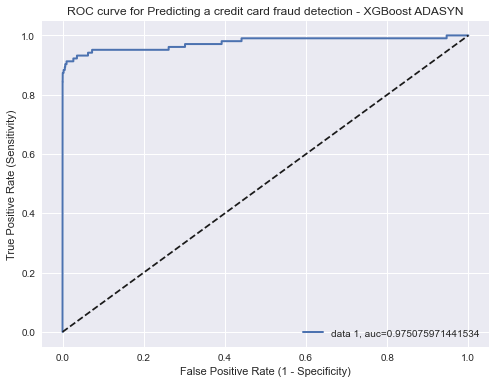

In [496]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr444, tpr444, thresholds = metrics.roc_curve(y_test, xg_pred_adasyn)

auc_xg_ADASYN = metrics.roc_auc_score(y_test, xg_pred_adasyn)
print("ROC-AUC score  - ",auc_xg_ADASYN,"\n")

plt.plot(fpr444,tpr444,linewidth=2, label="data 1, auc="+str(auc_xg_ADASYN))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection - XGBoost ADASYN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()



#### ADASYN sampling for AdaBoost and CATBoost

In [363]:
# ADASYN Sampling with Random Forest
# Train the classifiers

#ADAboost
clf2.fit(X_train_adasyn, y_train_adasyn)
#Catboost
clf3.fit(X_train_adasyn, y_train_adasyn)


0:	total: 523ms	remaining: 51.8s
50:	total: 27.4s	remaining: 26.3s
99:	total: 51.6s	remaining: 0us


In [364]:
#Predict the models
ada_pred_adasyn = clf2.predict(X_test) #AdaBoost
cat_pred_adasyn = clf3.predict(X_test) #CatBoost

In [471]:
print('Adaboost with ADASYN:')
acc21 = accuracy_score(y_test, ada_pred_adasyn) 
print("The accuracy is {}".format(acc12)) 
  
prec = precision_score(y_test, ada_pred_adasyn) 
print("The precision is {}".format(prec)) 
  
rec_ada_bal = recall_score(y_test, ada_pred_adasyn) 
print("The recall is {}".format(rec_ada_bal)) 
  
f1_ada_bal = f1_score(y_test, ada_pred_adasyn) 
print("The F1-Score is {}".format(f1_ada_bal))

print('\n')

print('catboost with ADASYN:')
acc31 = accuracy_score(y_test, cat_pred_adasyn) 
print("The accuracy is {}".format(acc12)) 
  
prec = precision_score(y_test, cat_pred_adasyn) 
print("The precision is {}".format(prec)) 
  
rec_cat_bal = recall_score(y_test, cat_pred_adasyn) 
print("The recall is {}".format(rec_cat_bal)) 
  
f1_cat_bal = f1_score(y_test, cat_pred_adasyn) 
print("The F1-Score is {}".format(f1_cat_bal))

Adaboost with ADASYN:
The accuracy is 0.9995786664794073
The precision is 0.16515426497277677
The recall is 0.883495145631068
The F1-Score is 0.2782874617737003


catboost with ADASYN:
The accuracy is 0.9995786664794073
The precision is 0.48633879781420764
The recall is 0.8640776699029126
The F1-Score is 0.6223776223776223


ROC-AUC score  -  0.9377024788110668 



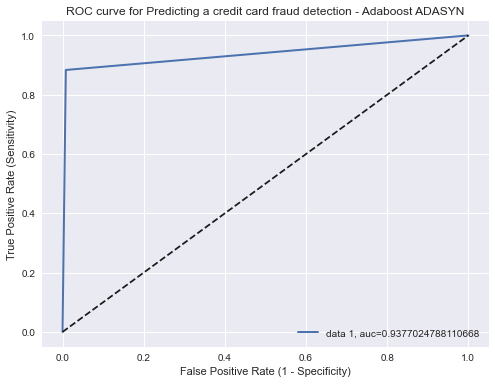

In [495]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr222, tpr222, thresholds = metrics.roc_curve(y_test, ada_pred_adasyn)

auc_ada_ADASYN = metrics.roc_auc_score(y_test, ada_pred_adasyn)
print("ROC-AUC score  - ",auc_ada_ADASYN,"\n")

plt.plot(fpr222,tpr222,linewidth=2, label="data 1, auc="+str(auc_ada_ADASYN))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection - Adaboost ADASYN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC-AUC score  -  0.9312122287853262 



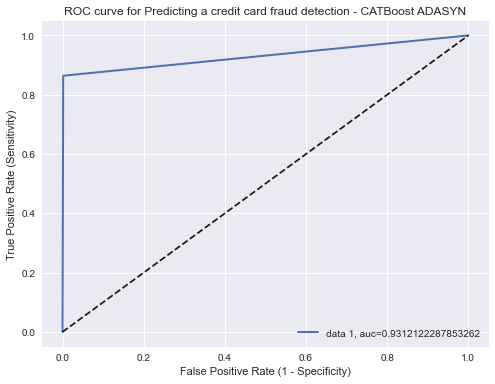

In [494]:
# plot Receiver Operating Characteristic (ROC) Curve

plt.figure(figsize=(8,6))

fpr333, tpr333, thresholds = metrics.roc_curve(y_test, cat_pred_adasyn)

auc_cat_ADASYN = metrics.roc_auc_score(y_test, cat_pred_adasyn)
print("ROC-AUC score  - ",auc_cat_ADASYN,"\n")

plt.plot(fpr333,tpr333,linewidth=2, label="data 1, auc="+str(auc_cat_ADASYN))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection - CATBoost ADASYN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

# Model Comparison 

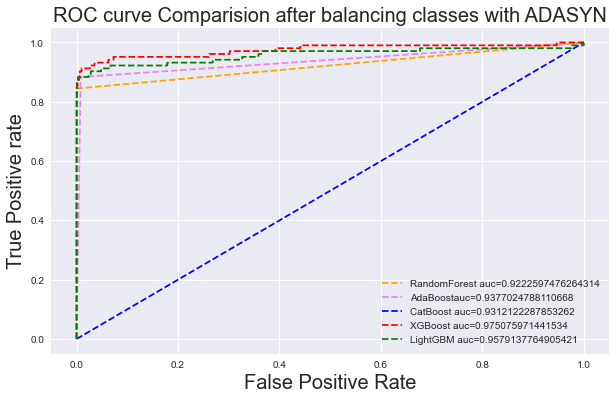

In [501]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(10,6))

# plot roc curves
plt.plot(fpr111, tpr111, linestyle='--',color='orange', label='RandomForest auc='+str(auc_rf_ADASYN))
plt.plot(fpr222, tpr222, linestyle='--',color='violet', label='AdaBoostauc='+str(auc_ada_ADASYN))
plt.plot(tpr333, tpr333, linestyle='--',color='blue', label='CatBoost auc='+str(auc_cat_ADASYN))
plt.plot(fpr444, tpr444, linestyle='--',color='red', label='XGBoost auc='+str(auc_xg_ADASYN))
plt.plot(fpr555, tpr555, linestyle='--',color='green', label='LightGBM auc='+str(auc_lg_ADASYN))
# title
plt.title('ROC curve Comparision after balancing classes with ADASYN', fontsize=20)
# x label
plt.xlabel('False Positive Rate', fontsize=20)
# y label
plt.ylabel('True Positive rate', fontsize=20)

plt.legend(loc='best')
plt.show()

#### Insights 

1. The best auc-roc score after oversampling the data using ADASYN was achieved by XGBoost - **0.97**, followed by LightGBM - **0.95**. 
2. We can see the models are achieving extremely high auc-roc scores. But now is auc-roc an accurate metric for our classification model? Let us compare recall scores to understand how well the model is predicting positive classes (is Fraud)

### Model Comparison using Recall Scores

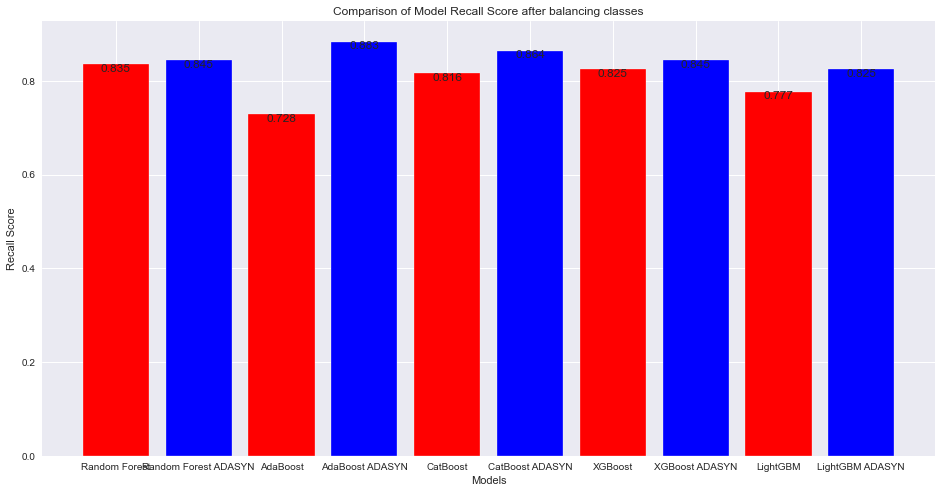

In [487]:
# Plotting the comparison
models1 = ['Random Forest','Random Forest ADASYN',  'AdaBoost', 'AdaBoost ADASYN', 'CatBoost', 'CatBoost ADASYN',
           'XGBoost', 'XGBoost ADASYN', 'LightGBM', 'LightGBM ADASYN']
recall_scores = [rec_rf, rec_rf_bal, rec_ada, rec_ada_bal, rec_cat, rec_cat_bal, rec_xg, rec_xg_bal, rec_lg, rec_lg_bal]

plt.figure(figsize=(16, 8))
bars1 = plt.bar(models1, recall_scores, color=['red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue'])
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Comparison of Model Recall Score after balancing classes')


# Annotate bars with accuracy values
for bar, recall in zip(bars1, recall_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{recall:.3f}', ha='center', va='bottom')

plt.show()

#### Insights

1. Recall scores improved significantly for all models. Most significantly for Adaboost. 
2. The best recall score was obtained for Adaboost - **0.88** which was initially 0.72, followed by Catboost - **0.86** which grew from 0.81, and **0.845** for both Random forest and XGBoost. 

This shows how after balancing the classes, models were able to identify positive classes (is fraud) more accurately. you could achieve **perfect recall** (but bad precision) using a naive classifier that **marked everything positive**. Let look at the f1 scores.


### Model Comparison using F1 score

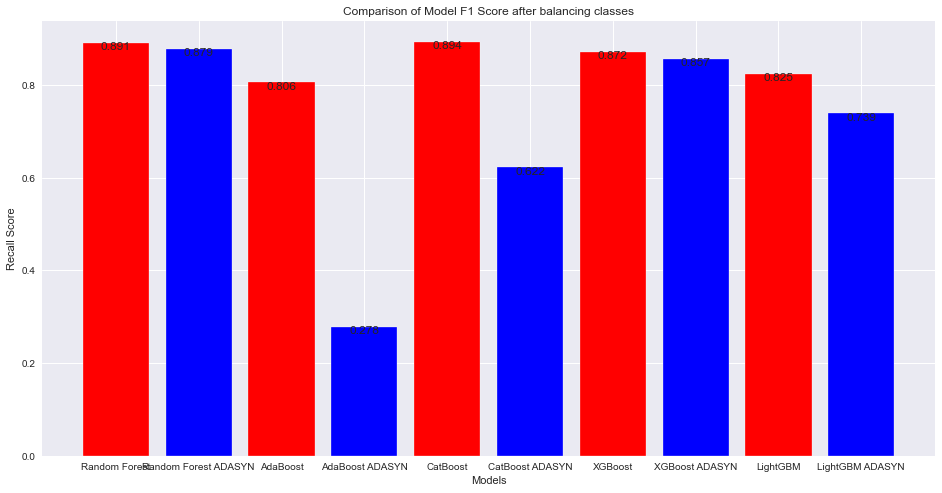

In [492]:
# Plotting the comparison
models2 = ['Random Forest','Random Forest ADASYN',  'AdaBoost', 'AdaBoost ADASYN', 'CatBoost', 'CatBoost ADASYN',
           'XGBoost', 'XGBoost ADASYN', 'LightGBM', 'LightGBM ADASYN']
f1_scores = [f1_rf, f1_rf_bal, f1_ada, f1_ada_bal, f1_cat, f1_cat_bal, f1_xg, f1_xg_bal, f1_lg, f1_lg_bal]

plt.figure(figsize=(16, 8))
bars1 = plt.bar(models2, f1_scores, color=['red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue'])
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Comparison of Model F1 Score after balancing classes')


# Annotate bars with accuracy values
for bar, f1 in zip(bars1, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{f1:.3f}', ha='center', va='bottom')

plt.show()

#### Insights

1. Observe how the f1 score dropped for all the models after balancing the classes, most significantly for AdaBoost and CATBoost, whose f1 scores were  0.80 and 0.89 respectively before balancing the classes that dropped to 0.27 and 0.67, respectively. 
2. This decrease in F1 scores underlines a critical insight: the intial model performances were high due to bias as the models achieved high metrics simply by predicting the majority class that is positive class i.e they favoured the majority class. So, the f1 score we achieved currently is more accurate and meaningful. 
3. It is worth noting, F1 score of 0.7 or higher is generally considered good. **Adaboost and CatBoost both got poor f1 scores of less than 0.7.** they did not even achieve the benchmark f1 score.
4. Observe, previously AdaBoost got an outstanding recall score positioning it as the best performing model as per recall score, but now after checking the f1 score the **ADABoost classifier was the weakest performer** compared to other models. This might be an indicator that the model struggled to identify negative classes (Not fraud) correctly.

The best f1 score after balancing the classes using ADASYN was achieved by **Random forests - 0.879**, followed by **XGBoost - 0.857**.

# Model Selection using Area Under Precision Recall Curve (AUPRC)

The area under the precision-recall curve (AUPRC) is a useful performance metric for imbalanced data in a problem setting where you care a lot about finding the positive examples. A perfect AUPRC signifies that the model was able to predict all positive classes accurately (i.e. obtained a perfect recall score) without mis-predicting any negative classes as positive (i.e. obtained a perfect precision score). AUPRC is a critical metric to calculate in problems where properly classifying the positives is important [14].

AUPRC is an efficient evaluation metric when the fraction of positive classes in a dataset is very less and are mostly populated by negative classes like in our credit card fraud detection dataset. 

Why do we look at the trade-off between precision and recall? It’s important to consider both recall and precision together, because you could achieve perfect recall (but bad precision) using a naive classifier that marked everything positive, and you could achieve perfect precision (but bad recall) using a naive classifier that marked everything negative [14].

A random classifier for Area under ROC will always be 0.5 but that is not the case for Area under PR curve, AUPRC baseline is decided based on the fraction of positive classes present in the dataset. For example, in our dataset the fraction of positive classes is only 0.2% so the baseline for AUPRC will be 0.02 (for the imbalanced classes) so an AUPRC of say 0.4 will also be a superior performance metric. But after balancing the classes, our dataset has 50% positive classes making the baseline of AUPRC as 0.5 effectively. The higher and further away AUPRC performance is from the baseline the better the AUPRC.  

There are many ways to calculate AUPRC, we are using average-precision to calculate the score.


In [502]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

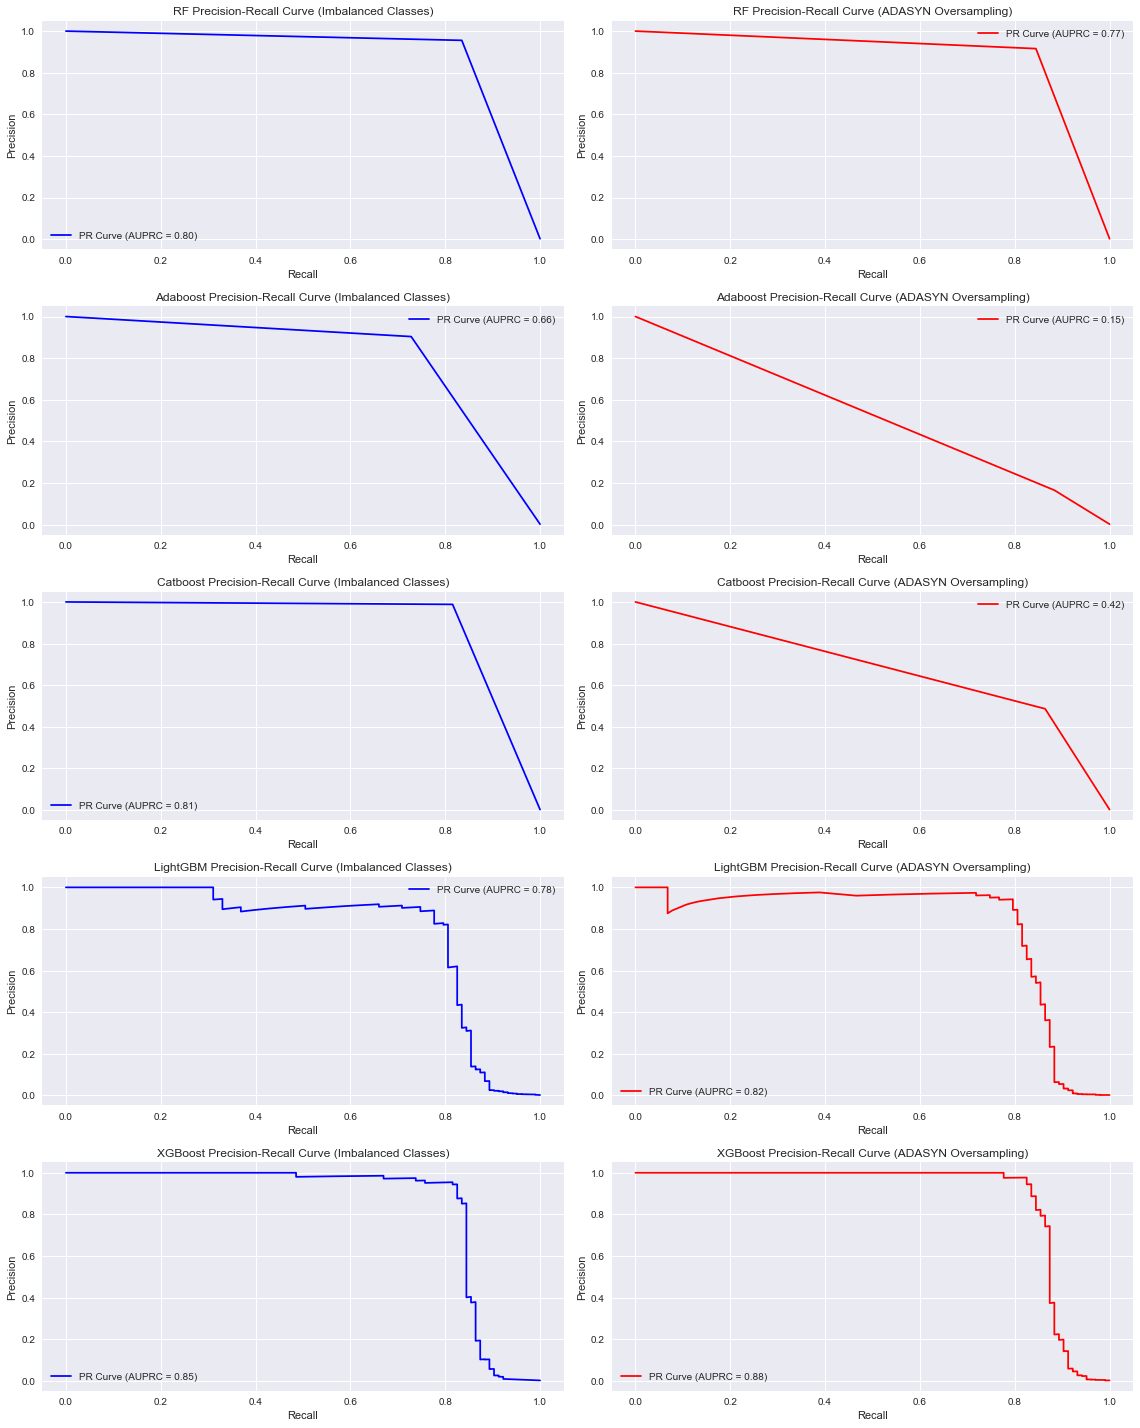

In [490]:
# Precision-Recall Curve for RF with imbalanced classes
precision_rf, recall_rf, _ = precision_recall_curve(y_test, preds_rf)
auprc_rf = average_precision_score(y_test, preds_rf)

# Precision-Recall Curve for RF with ADASYN oversampling
precision_adasyn_rf, recall_adasyn_rf, _ = precision_recall_curve(y_test, rf_pred_adasyn)
auprc_adasyn_rf = average_precision_score(y_test, rf_pred_adasyn)

# Precision-Recall Curve for Adaboost with imbalanced classes
precision_ada, recall_ada, _ = precision_recall_curve(y_test, preds_ada)
auprc_ada = average_precision_score(y_test, preds_ada)

# Precision-Recall Curve for Adaboost with ADASYN oversampling
precision_adasyn_ada, recall_adasyn_ada, _ = precision_recall_curve(y_test, ada_pred_adasyn)
auprc_adasyn_ada = average_precision_score(y_test, ada_pred_adasyn)

# Precision-Recall Curve for Catboost with imbalanced classes
precision_cat, recall_cat, _ = precision_recall_curve(y_test, preds_cat)
auprc_cat = average_precision_score(y_test, preds_cat)

# Precision-Recall Curve for Catboost with ADASYN oversampling
precision_adasyn_cat, recall_adasyn_cat, _ = precision_recall_curve(y_test, cat_pred_adasyn)
auprc_adasyn_cat = average_precision_score(y_test, cat_pred_adasyn)

# Precision-Recall Curve for LightGBM with imbalanced classes
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, preds_lgb)
auprc_lgb = average_precision_score(y_test, preds_lgb)

# Precision-Recall Curve for LightGBM with ADASYN oversampling
precision_adasyn_lgb, recall_adasyn_lgb, _ = precision_recall_curve(y_test, lg_pred_adasyn)
auprc_adasyn_lgb = average_precision_score(y_test, lg_pred_adasyn)

# Precision-Recall Curve for XGBoost with imbalanced classes
precision_xg, recall_xg, _ = precision_recall_curve(y_test, preds_xg)
auprc_xg = average_precision_score(y_test, preds_xg)

# Precision-Recall Curve for XGBoost with ADASYN oversampling
precision_adasyn_xg, recall_adasyn_xg, _ = precision_recall_curve(y_test, xg_pred_adasyn)
auprc_adasyn_xg = average_precision_score(y_test, xg_pred_adasyn)

# Plotting subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 20))

# Plot Precision-Recall Curve for RF
axs[0, 0].plot(recall_rf, precision_rf, color='blue', label=f'PR Curve (AUPRC = {auprc_rf:.2f})')
axs[0, 0].set_xlabel('Recall')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].set_title('RF Precision-Recall Curve (Imbalanced Classes)')
axs[0, 0].legend()

axs[0, 1].plot(recall_adasyn_rf, precision_adasyn_rf, color='red', label=f'PR Curve (AUPRC = {auprc_adasyn_rf:.2f})')
axs[0, 1].set_xlabel('Recall')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].set_title('RF Precision-Recall Curve (ADASYN Oversampling)')
axs[0, 1].legend()

# Plot Precision-Recall Curve for Adaboost
axs[1, 0].plot(recall_ada, precision_ada, color='blue', label=f'PR Curve (AUPRC = {auprc_ada:.2f})')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].set_title('Adaboost Precision-Recall Curve (Imbalanced Classes)')
axs[1, 0].legend()

axs[1, 1].plot(recall_adasyn_ada, precision_adasyn_ada, color='red', label=f'PR Curve (AUPRC = {auprc_adasyn_ada:.2f})')
axs[1, 1].set_xlabel('Recall')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].set_title('Adaboost Precision-Recall Curve (ADASYN Oversampling)')
axs[1, 1].legend()

# Plot Precision-Recall Curve for Catboost
axs[2, 0].plot(recall_cat, precision_cat, color='blue', label=f'PR Curve (AUPRC = {auprc_cat:.2f})')
axs[2, 0].set_xlabel('Recall')
axs[2, 0].set_ylabel('Precision')
axs[2, 0].set_title('Catboost Precision-Recall Curve (Imbalanced Classes)')
axs[2, 0].legend()

axs[2, 1].plot(recall_adasyn_cat, precision_adasyn_cat, color='red', label=f'PR Curve (AUPRC = {auprc_adasyn_cat:.2f})')
axs[2, 1].set_xlabel('Recall')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_title('Catboost Precision-Recall Curve (ADASYN Oversampling)')
axs[2, 1].legend()

# Plot Precision-Recall Curve for LightGBM
axs[3, 0].plot(recall_lgb, precision_lgb, color='blue', label=f'PR Curve (AUPRC = {auprc_lgb:.2f})')
axs[3, 0].set_xlabel('Recall')
axs[3, 0].set_ylabel('Precision')
axs[3, 0].set_title('LightGBM Precision-Recall Curve (Imbalanced Classes)')
axs[3, 0].legend()

axs[3, 1].plot(recall_adasyn_lgb, precision_adasyn_lgb, color='red', label=f'PR Curve (AUPRC = {auprc_adasyn_lgb:.2f})')
axs[3, 1].set_xlabel('Recall')
axs[3, 1].set_ylabel('Precision')
axs[3, 1].set_title('LightGBM Precision-Recall Curve (ADASYN Oversampling)')
axs[3, 1].legend()

# Plot Precision-Recall Curve for XGBoost
axs[4, 0].plot(recall_xg, precision_xg, color='blue', label=f'PR Curve (AUPRC = {auprc_xg:.2f})')
axs[4, 0].set_xlabel('Recall')
axs[4, 0].set_ylabel('Precision')
axs[4, 0].set_title('XGBoost Precision-Recall Curve (Imbalanced Classes)')
axs[4, 0].legend()

axs[4, 1].plot(recall_adasyn_xg, precision_adasyn_xg, color='red', label=f'PR Curve (AUPRC = {auprc_adasyn_xg:.2f})')
axs[4, 1].set_xlabel('Recall')
axs[4, 1].set_ylabel('Precision')
axs[4, 1].set_title('XGBoost Precision-Recall Curve (ADASYN Oversampling)')
axs[4, 1].legend()

plt.tight_layout()
plt.show()


#### Insights

As we can see the AUPRC was able to plot the positive classes (i.e. Is Fraud) within the dataset and illustrates how well the models performed while identifying the positive class or recognising fraudulent transactions. This metric shows which model was able to identify fraudulent transactions more accurately, and thus gives the best model which fulfils our initial objective of identifying fraud cases accurately. 

**For Imbalanced Classes**
1. The baseline AUPRC with the imbalanced classes is 0.02 as we have only 0.2% positive classes. The score which is higher than 0.02 and further away from this baseline is the superior AUPRC score. So, the best performing model for our objective is - **XGBoost - 0.85**, followed by **CatBoost -0.81** and **Random Forest - 0.80**.
2. As per the AUPRC results for imbalanced classes, **Adaboost - 0.66, LightGBM - 0.78 are weak performers**, compared to other models.
3. Notice how initially we achieved an accuracy of 0.99 for all our models, with LightGBM leading with best auc-roc score, which we now understand was inaccurate and we achieved these high metrics due to biases introduced by imbalanced classes(presence of 99.8% negative classes) in the dataset. AUPRC is a more accurate performance metric (for this classification problem) to compare the models and select the most optimum model - one that is able to classify not only the negative classes (not fraud) but also the positive classes (is Fraud) most accurately.


**For balanced Classes**
1. After oversampling, the baseline AUPRC rises to 0.5, as positive classes are now 50%, the best performing model for our objective is - again **XGBoost - 0.88**, followed by **LightGBM - 0.82** and **Random Forest - 0.77**.
2. As per the AUPRC results for balanced classes, **Adaboost - 0.15, LightGBM - 0.42 are poor performers**, as they are **less than 0.5 AUPRC baseline**.
3. Notice how drastically the results have changed from imbalanced classes. This underscores the importance of balancing the classes. Earlier, Catboost, performed better than LightGBM in imbalanced dataset but after ADASYN oversampling, Catboost did not even achieve the baseline of 0.5 and hence is not a suitable model for our dataset. On the other hand, Adaboost performed poorly in both cases. In contrast, LightGBM  demonstrates robust performance and was able to achieve a high AUPRC score of 0.82, highlighting its efficacy in accurately identifying fraud cases. 


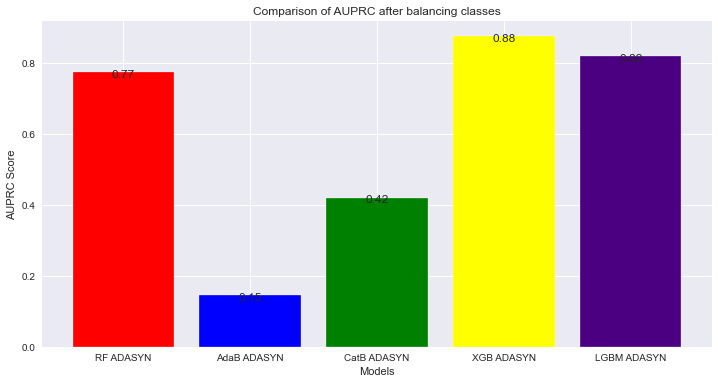

In [457]:
# Plotting the comparison
models11 = ['RF ADASYN', 'AdaB ADASYN',  'CatB ADASYN', 'XGB ADASYN', 'LGBM ADASYN']
auprc_score = [auprc_adasyn_rf, auprc_adasyn_ada, auprc_adasyn_cat, auprc_adasyn_xg, auprc_adasyn_lg]

plt.figure(figsize=(12, 6))
bars1 = plt.bar(models11, auprc_score, color=['red', 'blue', 'green', 'yellow', 'indigo'])
plt.xlabel('Models')
plt.ylabel('AUPRC Score')
plt.title('Comparison of AUPRC after balancing classes')


# Annotate bars with accuracy values
for bar, auprc in zip(bars1, auprc_score):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{auprc:.2f}', ha='center', va='bottom')

plt.show()

In [ ]:
'''rec_score_adasyn1 = [rec_rf_bal, rec_ada_bal, rec_cat_bal, rec_xg_bal, rec_lg_bal]
f1_score_adasyn1 = [f1_rf_bal, f1_ada_bal, f1_cat_bal, f1_xg_bal, f1_lg_bal]

rec_score1 = [rec_rf, rec_ada, rec_cat, rec_xg, rec_lg]
f1_score1 = [f1_rf, f1_ada, f1_cat, f1_xg, f1_lg]

models_all = ['Random Forest', 'AdaBoost', 'XGboost', 'LightGBM']

for model, recall, f1, recadasyn, f1adasyn in zip(models_all, rec_score1, f1_score1, rec_score_adasyn1, f1_score_adasyn1):
    print(model, ' with imbalanced classes: f1_Score = ', f'{f1:.2f}', '; recall score = ', f'{recall:.2f}')
    print(model, ' with balanced classes: f1_Score = ', f'{f1adasyn:.2f}', '; recall score = ', f'{recadasyn:.2f}')
    print("\n")'''

# Results and Conclusion

The Dataset chosen for the project of credit card fraud detection was a classification problem. It contained highly imbalanced classes. After extensive data exploration we found some interesting analysis. 

**1. Exploratory Data Analysis (EDA)**
- The dataset consisted of a mere 0.2% of transaction as fraudulent that is 492 fraud cases in a total of 2,84,807 transactions indicating severe class imbalance.
- Analysing the feature 'Amount' revealed a positively skewed distribution, with minimum value of 0 and maximum value of 25691.16. The average amount of fraudulent transactions was around 122.2, while the average amount for genuine transaction was 88.2. 
- On analysing the distribution of 'Amount' for fraudulent transactions we found about 27 transactions for an amount of 0, these could be Zero value transactions used for verification of credit cards. These could be a result of leaked credit card information being verified and once validated will be used to charge the credit card for purchases with a new transaction.
- Looking at the distribution of time with respect to classes, we were able to identify two peaks when most of the transaction were made during the daytime in the plot for Genuine Transactions, as the data is for credit card transaction done over two days.
- The Fraudulent transactions varied between 0 to 2000 and the genuine transactions varied between 0 to 25000. Genuine transactions have higher density between the amount 0 to 10000 with a few high value transactions. Although the fraudulent transactions showed high degree of variations, they did not exhibit any distinct patterns for amount and time.
- We then analysed the correlation, which suggested features V1 to V28 (PCA components) are not correlated to each other. Some correlation was seen for explanatory variables Time, Amount and Class. However, even these variables were not highly correlated. Suggesting absence of any significant multicollinearity. 
- We then created density plots, and found that the feature distribution for genuine transaction varied around zero while the fraudulent transaction had an asymmetric distribution.

**2. Predictive modelling for imbalanced classes:**
- Next, we trained 5 classifiers namely random forest, Adaboost, Catboost, XGBoost and LightGBM on the dataset. We evaluated these models and got very high accuracy for all the models which is a result of bias introduced to class imbalance. We also evaluated the Area under ROC, the **ROC - AUC score** for 
    1. Random Forest - **0.91**
    2. AdaBoost -**0.86**
    3. Catboost - **0.91**
    4. XGBoost - **0.95**
    5. LightGBM - **0.97**
- We also achieved a high **accuracy of 0.99** for all the models. But these metrics could be misleading, due to bias introduced by imbalanced classes. It is important to note that a good auc-roc score does not necessarily mean a good precision-recall score. 

**3. Balancing Imbalanced classes and modelling:**

- We used techniques like SMOTE and ADASYN to address the class imbalance issue. After this we trained out models again on the data resampled with ADASYN.
- Post-resampling and we observed improvements in recall, f1 score, and AUPRC.

**4. Model Comparison:**
- On evaluating these models trained on balanced dataset, we observed how the Area under the precision-recall curve varied for each model with imbalanced classes and balanced classes. The best auc-roc score after oversampling the data using ADASYN was achieved by XGBoost - 0.97, followed by LightGBM - 0.95.
- Next, we compared the recall score, f1 score and AUPRC of all models for both balanced and imbalanced classes. We obtained following results -
1. Recall score for all models improved and most significantly for Adaboost. The best recall score was obtained for Adaboost - **0.88**, followed by Catboost - **0.86**, and **08.45** for both Random Forest and XGBoost. This shows how after balancing the classes, models were able to identify positive classes (is fraud) more accurately. you could achieve perfect recall (but bad precision) using a naive classifier that marked everything positive.
2. Next we observed how the f1 score changed after balancing the classes. The f1 score fell for all the models after balancing the classes, most significantly for AdaBoost and CATBoost. As these models were biased due to high class imbalance and the models achieved high metrics simply by predicting the majority class that is positive class. So, the f1 score we achieved now is more correct and meaningful. The best f1 score after balancing the classes using ADASYN was achieved by Random forests - **0.879**, followed by XGBoost - **0.857**. F1 score of 0.7 or higher is generally considered good. Adaboost and CatBoost both got poor f1 scores of less than 0.7. This might be an indicator that the models did not identify negative classes (Not fraud) correctly (although they achieved very high recall scores).
3. Lastly, we compared the AUPRC scores for imbalanced and balanced classes. The baseline AUPRC with the imbalanced classes was 0.02. So, the best performing model for our objective is - **XGBoost - 0.85, followed by CatBoost -0.81 and Random Forest - 0.80. Adaboost - 0.66, LightGBM - 0.78 are poor performers, **compared to other models. Notice how initially we achieved an accuracy of 0.99 for all our models, and the best performing model as per auc-roc score was LightGBM, which we now understand was inaccurate and we achieved these high metrics due to biases in models. Hence, we can conclude that AUPRC is a more accurate performance metric (for this classification problem) to compare the models and select the most optimum model - which is able to classify not only the negative classes (not fraud) but also the positive classes (is Fraud) most accurately.
4. The baseline AuPRC **after ADASYN oversampling** was 0.5, the **best performing model** for our objective was - again **XGBoost - 0.88, followed by LightGBM - 0.82 and Random Forest - 0.77. Adaboost - 0.15, LightGBM - 0.42 are poor performers, as they are less than 0.5 AUPRC baseline.**

After comprehensive analysis and comparison -

- The model performances changes drastically post resampling, highlighting the importance of balancing the classes.
- XGBoost consistently outperforms other models in both imbalanced and balanced class scenarios.
- While models initially showed high accuracy and AUC-ROC scores, the AUPRC metric proved more accurate in assessing model performance.

# Final Recommendations

In conclusion, **XGBoost** stands out as the most suitable and robust model for accurately predicting credit card fraud. It proved to be a reliable model especially after balancing the classes, highlighting its efficiency in identifying fraudulent and non-fraudulent transactions accurately. Additionally, insights gained from comprehensive analysis and model evaluations highlighted the importance of using the appropriate evaluation metrics and addressing class imbalance for reliable model selection and prediction in credit card fraud detection.

# References

1. https://developer.pxp-solutions.com/docs/zero-value-transaction#:~:text=A%20Zero%20Value%20Transaction%20enables,presenting%20the%20transaction%20for%20authorisation.
2. What is random forest? - https://www.ibm.com/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,both%20classification%20and%20regression%20problems.
3. A Simple Explanation of Gini Impurity - https://victorzhou.com/blog/gini-impurity/
4. Confusion matrix in machine learning - https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
5. Understanding the ROC and AUC Intuitively - https://medium.com/@shaileydash/understanding-the-roc-and-auc-intuitively-31ca96445c02
6. Guide to AUC ROC Curve in Machine Learning : What Is Specificity? - https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
7. Classification: ROC Curve and AUC -  https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=AUC%20stands%20for%20%22Area%20under,across%20all%20possible%20classification%20thresholds.
8. AdaBoost Algorithm in Machine Learning - https://www.almabetter.com/bytes/tutorials/data-science/adaboost-algorithm
9. LightGBM (Light Gradient Boosting Machine) - https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-mach
10. SMOTE for Imbalanced Classification with Python - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
11. Imbalanced Learning: Foundations, Algorithms, and Applications 1st Edition, by Haibo He (Editor), Yunqian Ma (Editor)
12. Fixing Imbalanced Datasets: An Introduction to ADASYN - https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa
13. Measuring Performance: AUPRC and Average Precision - https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/
14. Performance (AUPRC) - https://docs.rapidminer.com/latest/studio/operators/extensions/Operator
15. Dataset taken from kaggle - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud